In [36]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string, timeit
from collections import defaultdict
import operator
import gensim
from sklearn.decomposition import TruncatedSVD
from collections import Counter
from wordcloud import WordCloud
from matplotlib import pyplot as plt

In [37]:
 #we save it 
#data.to_csv('StarTrekTNG_test.csv', index=False )

In [3]:
df = pd.read_csv("StarTrekTNG_test.csv")

In [4]:
# Rename Character column so we can do some cleaning on it and save results to new column with 'Character'
#df.rename(columns = {"Character": 'Char'})

## Cleaning 

In [38]:
#lets get rid of descriptions between parenthesesis and brackets
for i in df.dialogue:
    if '[' in i or '(' in i:
        df.dialogue[df.dialogue == i] = re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", i)

C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [39]:
#let's get rid of some extra punctiation

string.punctuation

punct = set()
punct.add('(')
punct.add(')')
punct.add(']')
punct.add('[')
punct.add('-')
punct.add('“')
punct.add('"')

#for i in df.dialogue:
#    df.dialogue[df.dialogue == i] = ''.join(ch for ch in i if ch not in punct)

In [40]:
df['dialogue'] = df['dialogue'].apply(lambda x : x.replace(' . ',''))
df['dialogue'] = df['dialogue'].apply(lambda x : x.replace(' , ',''))
df['dialogue'] = df['dialogue'].apply(lambda x : x.replace('–','')) 
df['dialogue'] = df['dialogue'].apply(lambda x : x.replace('…','...'))
df['dialogue'] = df['dialogue'].apply(lambda x : x.replace('(',''))
df['dialogue'] = df['dialogue'].apply(lambda x : x.replace(')',''))

In [58]:
df.head(5)

Unnamed: 0 Character                                           dialogue  \
0           2    PICARD   You will agree, Data, that Starfleet's orders...   
1           3      DATA   Difficult? Simply solve the mystery of Farpoi...   
2           4    PICARD                                 As simple as that.   
3           5      TROI   Farpoint Station. Even the name sounds myster...   
4           6    PICARD   It's hardly simple, Data, to negotiate a frie...   

   season  chapter      to    Character-to  \
0       1        1    DATA  PICARD, DATA:    
1       1        1  PICARD  DATA, PICARD:    
2       1        1    TROI  PICARD, TROI:    
3       1        1  PICARD  TROI, PICARD:    
4       1        1    DATA  PICARD, DATA:    

                                       free_dialogue  
0   you will agree data that starfleets orders ar...  
1   difficult simply solve the mystery of farpoin...  
2                                  as simple as that  
3   farpoint station even the name sounds mysterious  
4   its hardly simple data to negotiate a friendl...

In [42]:
df = df[~df['Character'].isin(['Stardate', 'Original Airdate'])]

In [10]:
df['Character'][-2:]

64599      TROI
64600    PICARD
Name: Character, dtype: object

In [11]:
df['Character'] = df['Character'].apply(lambda x: x.replace("[OC]", "").rstrip())

In [12]:
def combine_OCs(x):
    if x['Character'][-1:] == '2':
        return x['Character'][:-2]
    else:
        return x['Character']
    
df['Character'] = df.apply(combine_OCs, axis=1)

# PART II: Analysis

In [13]:
import seaborn as sns

In [14]:
sns.set(rc={'figure.figsize':(11.7,8.27)}) #To make our graphs bigger

In [15]:
#Let us say the top 20 characters with most dialogues

order = df.Character.value_counts()[:21].index # I created the variable to use it for the barchart.

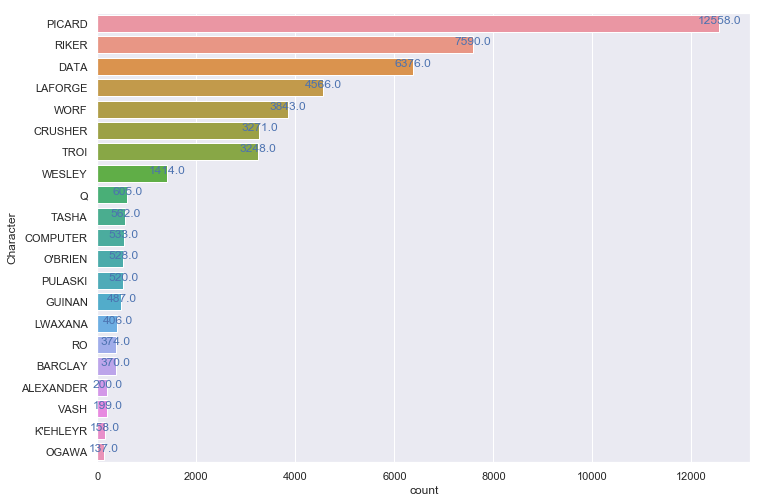

In [16]:
sns.countplot(data = df, y ='Character', order = order)
cat_counts = df['Character'].value_counts()[:21]
for i in range(len(cat_counts)):
    counts = cat_counts[i]

    pct_string = '{:0.1f}'.format(counts)

    # print the annotation just below the top of the bar
    plt.text(counts+1,i, pct_string, ha = 'center', color = 'b');

# Top 20 characters by dialogue proportion

In [17]:
import matplotlib.pyplot as plt

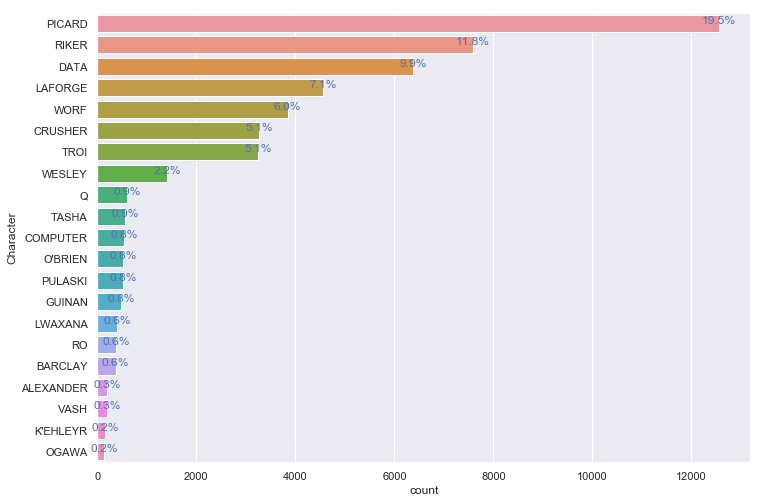

In [18]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

order = df.Character.value_counts()[:21].index


base_color = sns.color_palette()[0]
sns.countplot(data = df, y = 'Character',  order = order)


n_points = df.shape[0]
cat_counts = df['Character'].value_counts()[:21]
locs, labels = plt.yticks() 


for i in range(len(cat_counts)):
    counts = cat_counts[i]

    pct_string = '{:0.1f}%'.format(100*counts/n_points)

    
    plt.text(counts+1,i, pct_string, ha = 'center', color = 'b')

This shows what we all knew, Picard has the most lines and total words. Almost one fifth of all spoken words on the show are his.  Perhaps the most suprising is that Q, who only appears in 12 episodes, comes in the top 10 characters of total dialogue. The computer also has more lines than perhaps expected.

What are the top 50 characters

In [19]:
df.Character.value_counts()[:50]

PICARD       12558
RIKER         7590
DATA          6376
LAFORGE       4566
WORF          3843
CRUSHER       3271
TROI          3248
WESLEY        1414
Q              605
TASHA          562
COMPUTER       533
O'BRIEN        528
PULASKI        520
GUINAN         487
LWAXANA        406
RO             374
BARCLAY        370
ALEXANDER      200
VASH           199
K'EHLEYR       158
OGAWA          137
JELLICO        131
MORIARTY       119
GOWRON         113
LEAH           113
LORE           112
SOREN          109
SCOTT          108
SHELBY         105
RASMUSSEN      101
NELLA          101
AMANDA         100
CLARA           96
KAMALA          96
ARMUS           96
SALIA           94
KURN            91
KYLE            91
JAMESON         89
KEIKO           89
MARR            89
FARALLON        88
TIMICIN         88
CREWMAN         87
K'MTAR          85
BORG            85
SATIE           84
JULIANA         83
ZORN            82
ALKAR           78
Name: Character, dtype: int64

### Now let us check the number of words each character has spoken

We will remove all punctuation from the dialogue by creating a new column and then count the number of words of that column value for each row

In [11]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
punct = set(string.punctuation)

#Free of punctiations dialogue
df['free_dialogue']= df['dialogue'].apply(lambda x :''.join(ch.lower() for ch in x if ch not in punct))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ben\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ben\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
#We create a tokenize variable of the free dialogue to count seoparate the words and count them
df['tokenized_sents'] = df.apply(lambda row: nltk.word_tokenize(row['free_dialogue']), axis=1)

In [22]:
#Get number of words per dialogue
df['number_of_words'] = df.tokenized_sents.apply(lambda x: len(x))

In [23]:
j = df.groupby('Character')['number_of_words'].sum().sort_values(ascending=False)[:21].to_frame()
j['char'] = j.index
j.head(20)

number_of_words      char
Character                           
PICARD              147802    PICARD
DATA                 83544      DATA
RIKER                73298     RIKER
LAFORGE              57210   LAFORGE
CRUSHER              42327   CRUSHER
TROI                 36537      TROI
WORF                 33906      WORF
WESLEY               13356    WESLEY
Q                    10197         Q
LWAXANA               6394   LWAXANA
PULASKI               6162   PULASKI
TASHA                 5659     TASHA
GUINAN                5581    GUINAN
O'BRIEN               5126   O'BRIEN
BARCLAY               4377   BARCLAY
RO                    4335        RO
COMPUTER              3964  COMPUTER
LORE                  2234      LORE
JELLICO               2158   JELLICO
MORIARTY              2116  MORIARTY

It appears Data has a broader vocabulary than Riker even though Riker has more dialogue.  Troi and Dr. Crusher also have a higher diversity of unique words that Worf, who has more total dialouge.  A lot of the time, Worf says similar lines such as "We are being hailed", protocol lines that appear frequently.

### Top 20 characters by spoken word

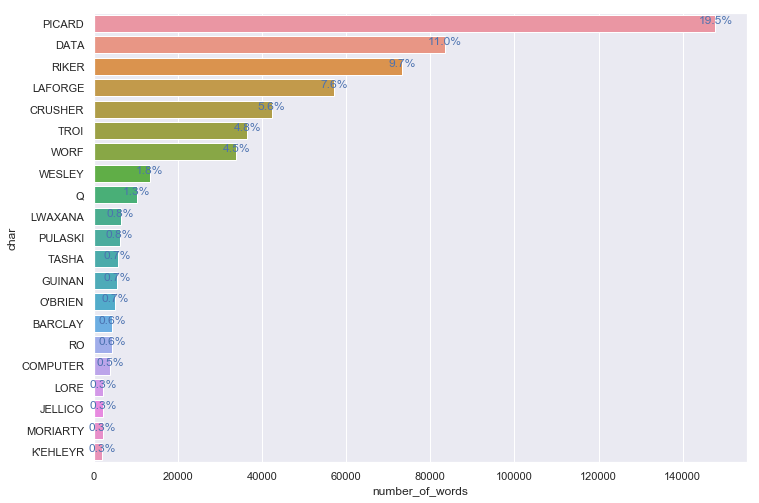

In [24]:
sns.barplot(data = j, x = 'number_of_words',y ='char' );
i = 0
for x, v in df.groupby('Character')['number_of_words'].sum().sort_values(ascending=False)[:21].items():
    counts = v 

    pct_string = '{:0.1f}%'.format(100*counts/df.number_of_words.sum())

    # print the annotation just below the top of the bar
    
    plt.text(counts+1,i, pct_string, ha = 'center', color = 'b')
    i += 1

### Words per dialogue violin plot top 5 Characters

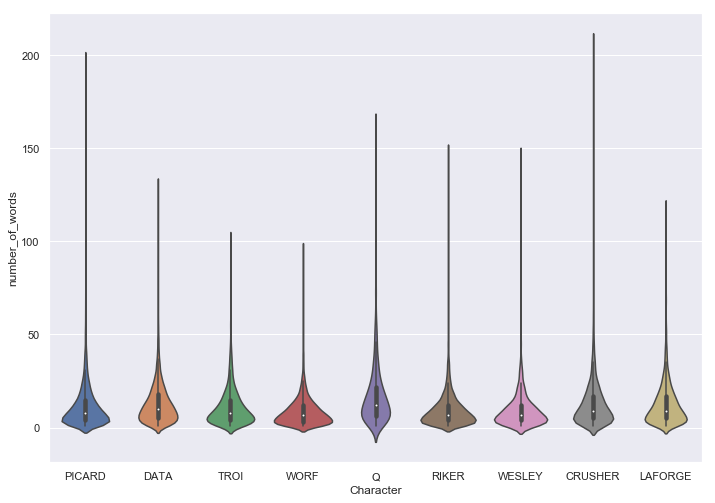

In [25]:
sns.violinplot(data = df.loc[df['Character'].isin(['PICARD','DATA','RIKER','LAFORGE', 'CRUSHER', 'TROI', 'WORF', 'WESLEY', 'Q'])], 
              x = 'Character', y = 'number_of_words');

This shows us that while Dr. Crusher is 6th is total dialogue in the series, on average she has the most words spoken whenever she does have lines.  Q, who 

### Longest dialogue of the dataset

In [26]:
df.loc[df.number_of_words > 350,:]

Character                                           dialogue  season  \
8818     TASHA   Hello, my friends. You are here now watching ...       1   

      chapter                                      free_dialogue  \
8818       22   hello my friends you are here now watching th...   

                                        tokenized_sents  number_of_words  
8818  [hello, my, friends, you, are, here, now, watc...              383

Tashas farewell address to her crew is the longest single dialogue in the series

In [27]:
df.loc[8818][1] #Index of the longest dialogue

" Hello, my friends. You are here now watching this image of me because I have died. It probably happened while I was on duty, and quickly, which is what I expected. Never forget I died doing exactly what I chose to do. What I want you to know is how much I loved my life, and those of you who shared it with me. You are my family. You all know where I came from and what my life was like before. But Starfleet took that frightened, angry young girl and tempered her. I have been blessed with your friendship and your love. Will Riker, you are the best. You trusted me, you encouraged me, and most of all you made me laugh. Deanna, you are capable of so much love. You taught me without ever having to say a word. I realised I could be feminine without losing anything. Ah, Worf. We are so much alike, you and I. Both warriors, orphans who found ourselves this family. I hope I met death with my eyes wide open. Beverly. Your fierce devotion comes from within. It can't be diminished. From you, I hav

## What are our characters actually saying? 

### Removing stop words 

In [28]:
from nltk.corpus import stopwords

In [29]:
stop_words = set(stopwords.words('english'))

In [30]:
#Stopwords free dialogue
df['tokenized_non_stopwords'] = df['tokenized_sents'].apply(lambda x: [item for item in x if item not in stop_words])

In [31]:
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

# Reduce words to their root form

df['lemmatize_words'] = df['tokenized_non_stopwords'].apply(lambda x: [WordNetLemmatizer().lemmatize(item,pos='v') for item in x])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ben\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
# A function to plot
def plotter(name):
    '''
    Creates a word plot of the top 60 most used words by any given character. It assumes a pandas Dataframe with the needed data. 
    Input: Str. Character name
    Output: Wordcloud plot of the most common words in that character dialogues.
    '''
    kinoa = []
    for i, v in df.lemmatize_words[df.Character == name].items():
        kinoa.extend(v)
    kinoa_= Counter(kinoa)
    wc = WordCloud(max_words =60,background_color='white', scale =3 , stopwords=set('one')).generate_from_frequencies(kinoa_)
    plt.figure( figsize=(100,50) ).suptitle(name, fontsize=300)
    plt.imshow(wc);

## Top 5 character most used words

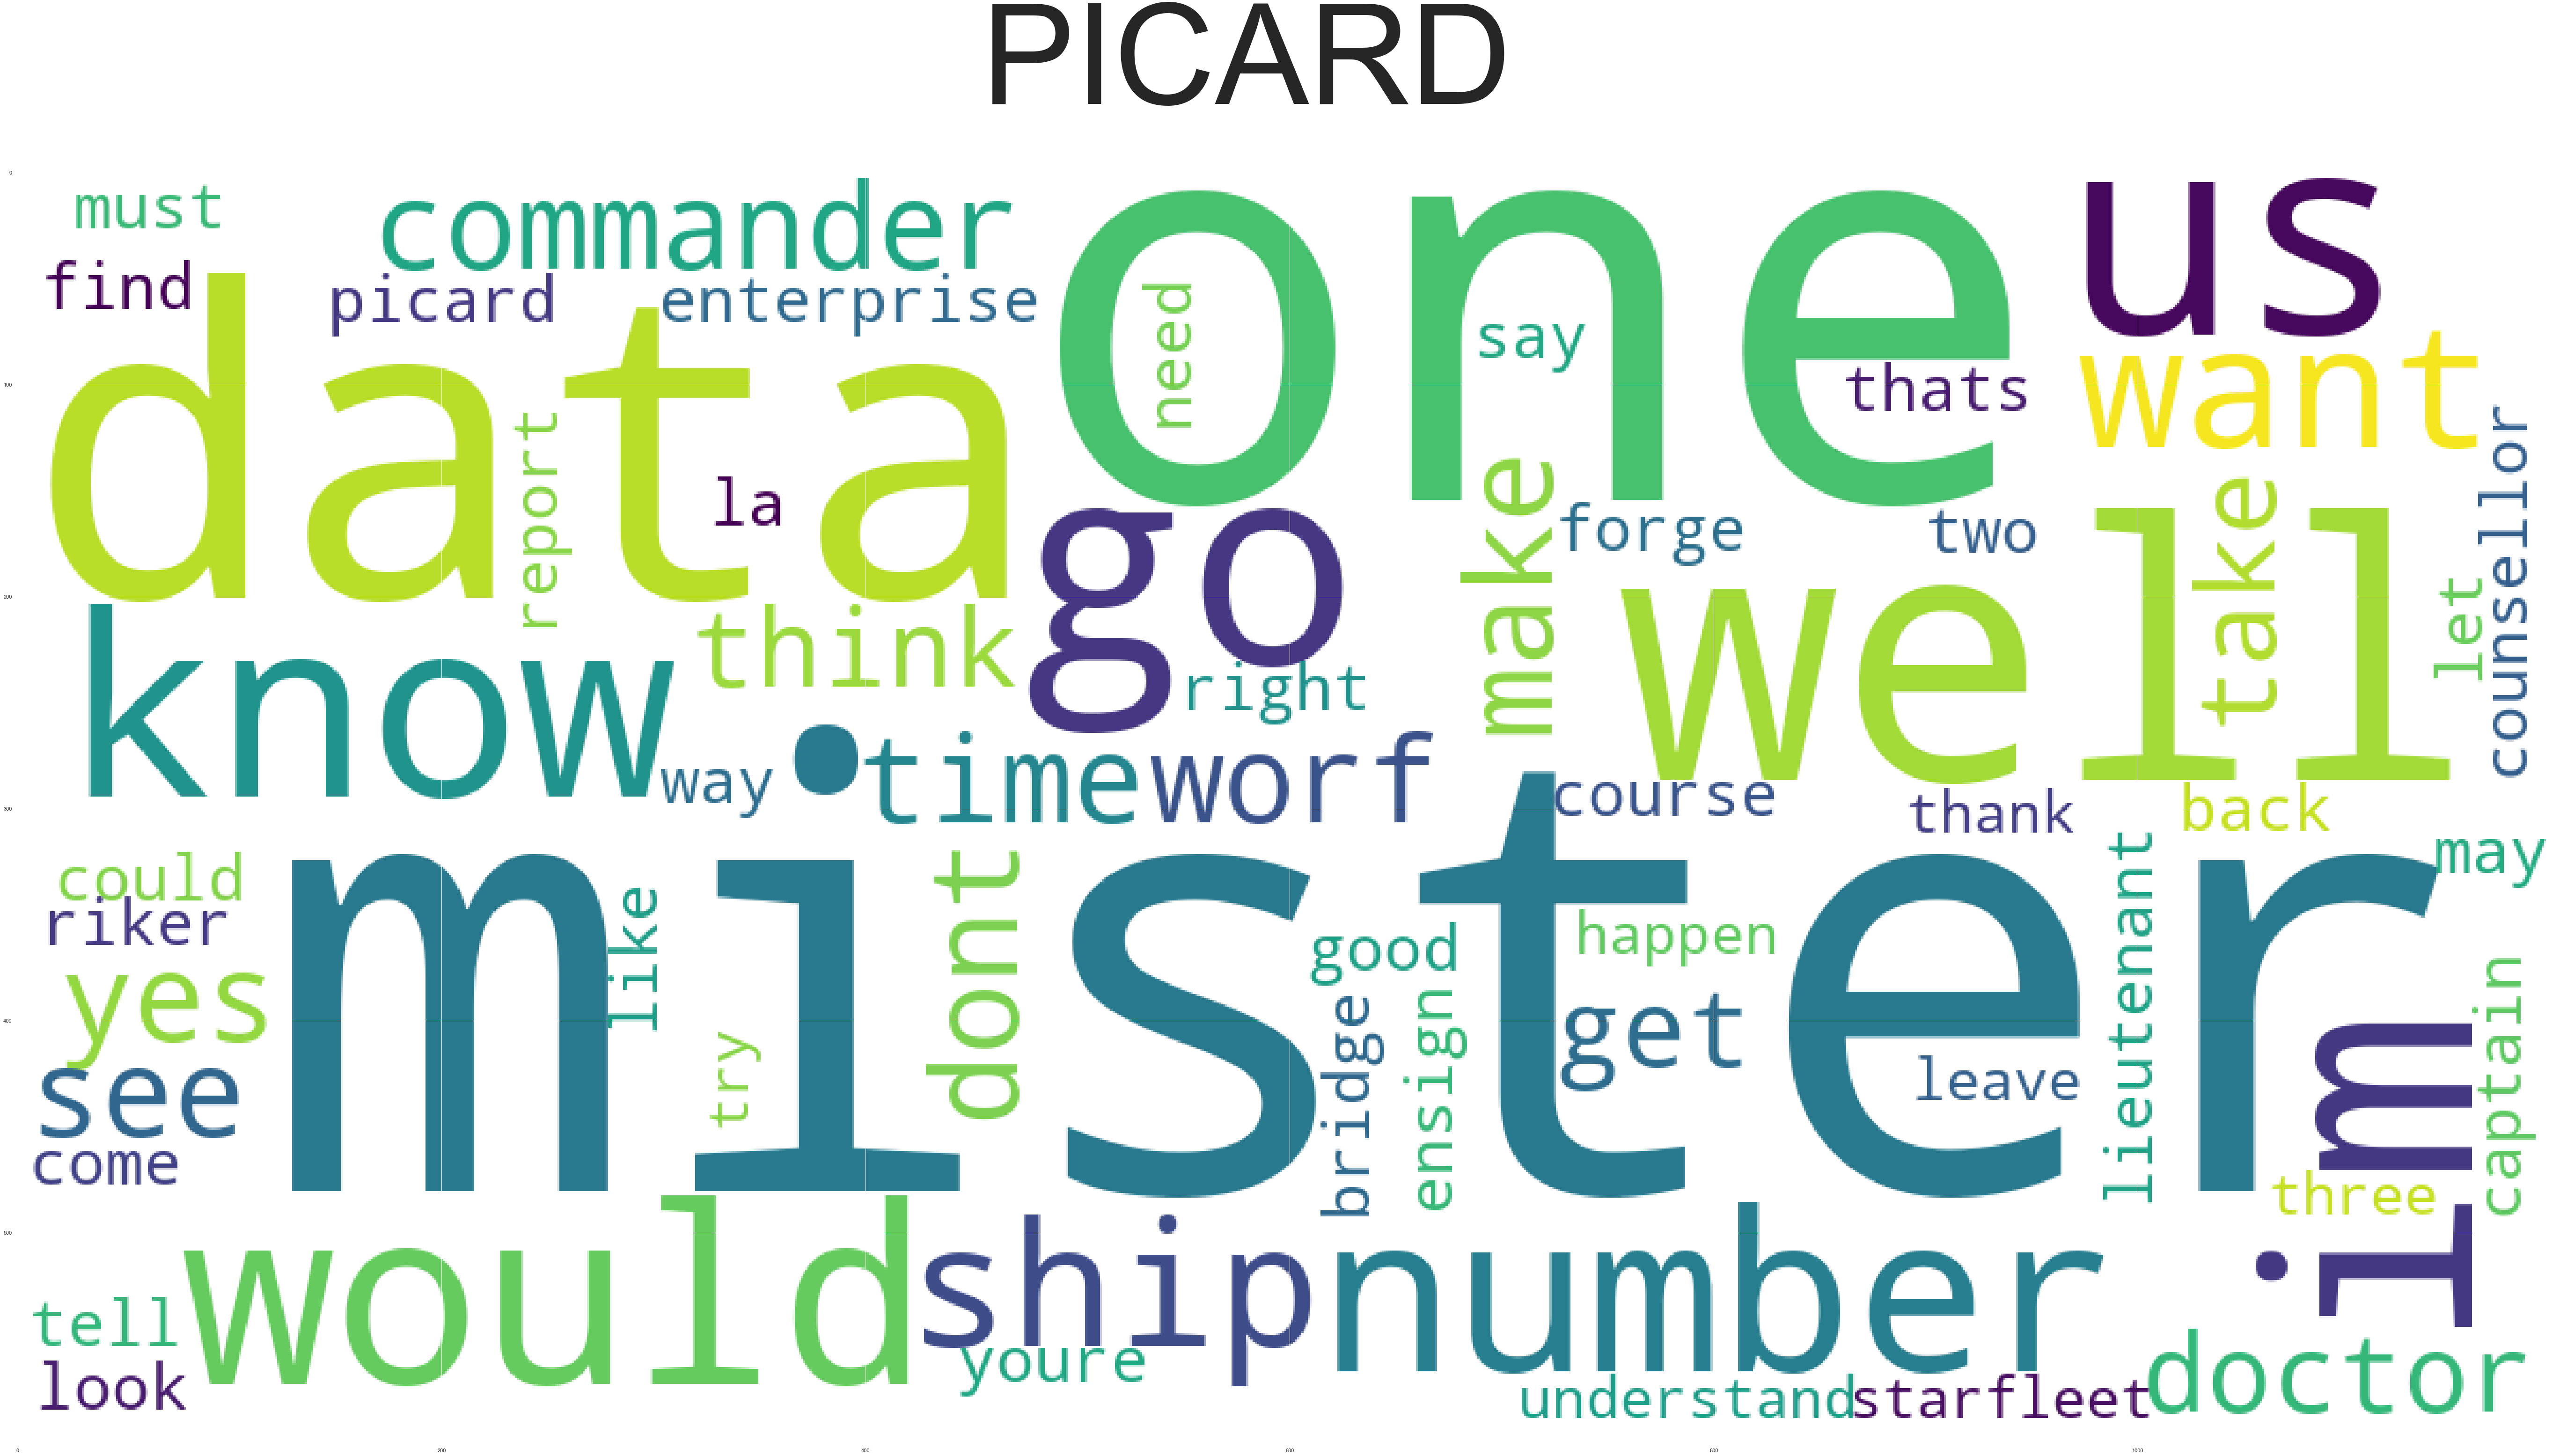

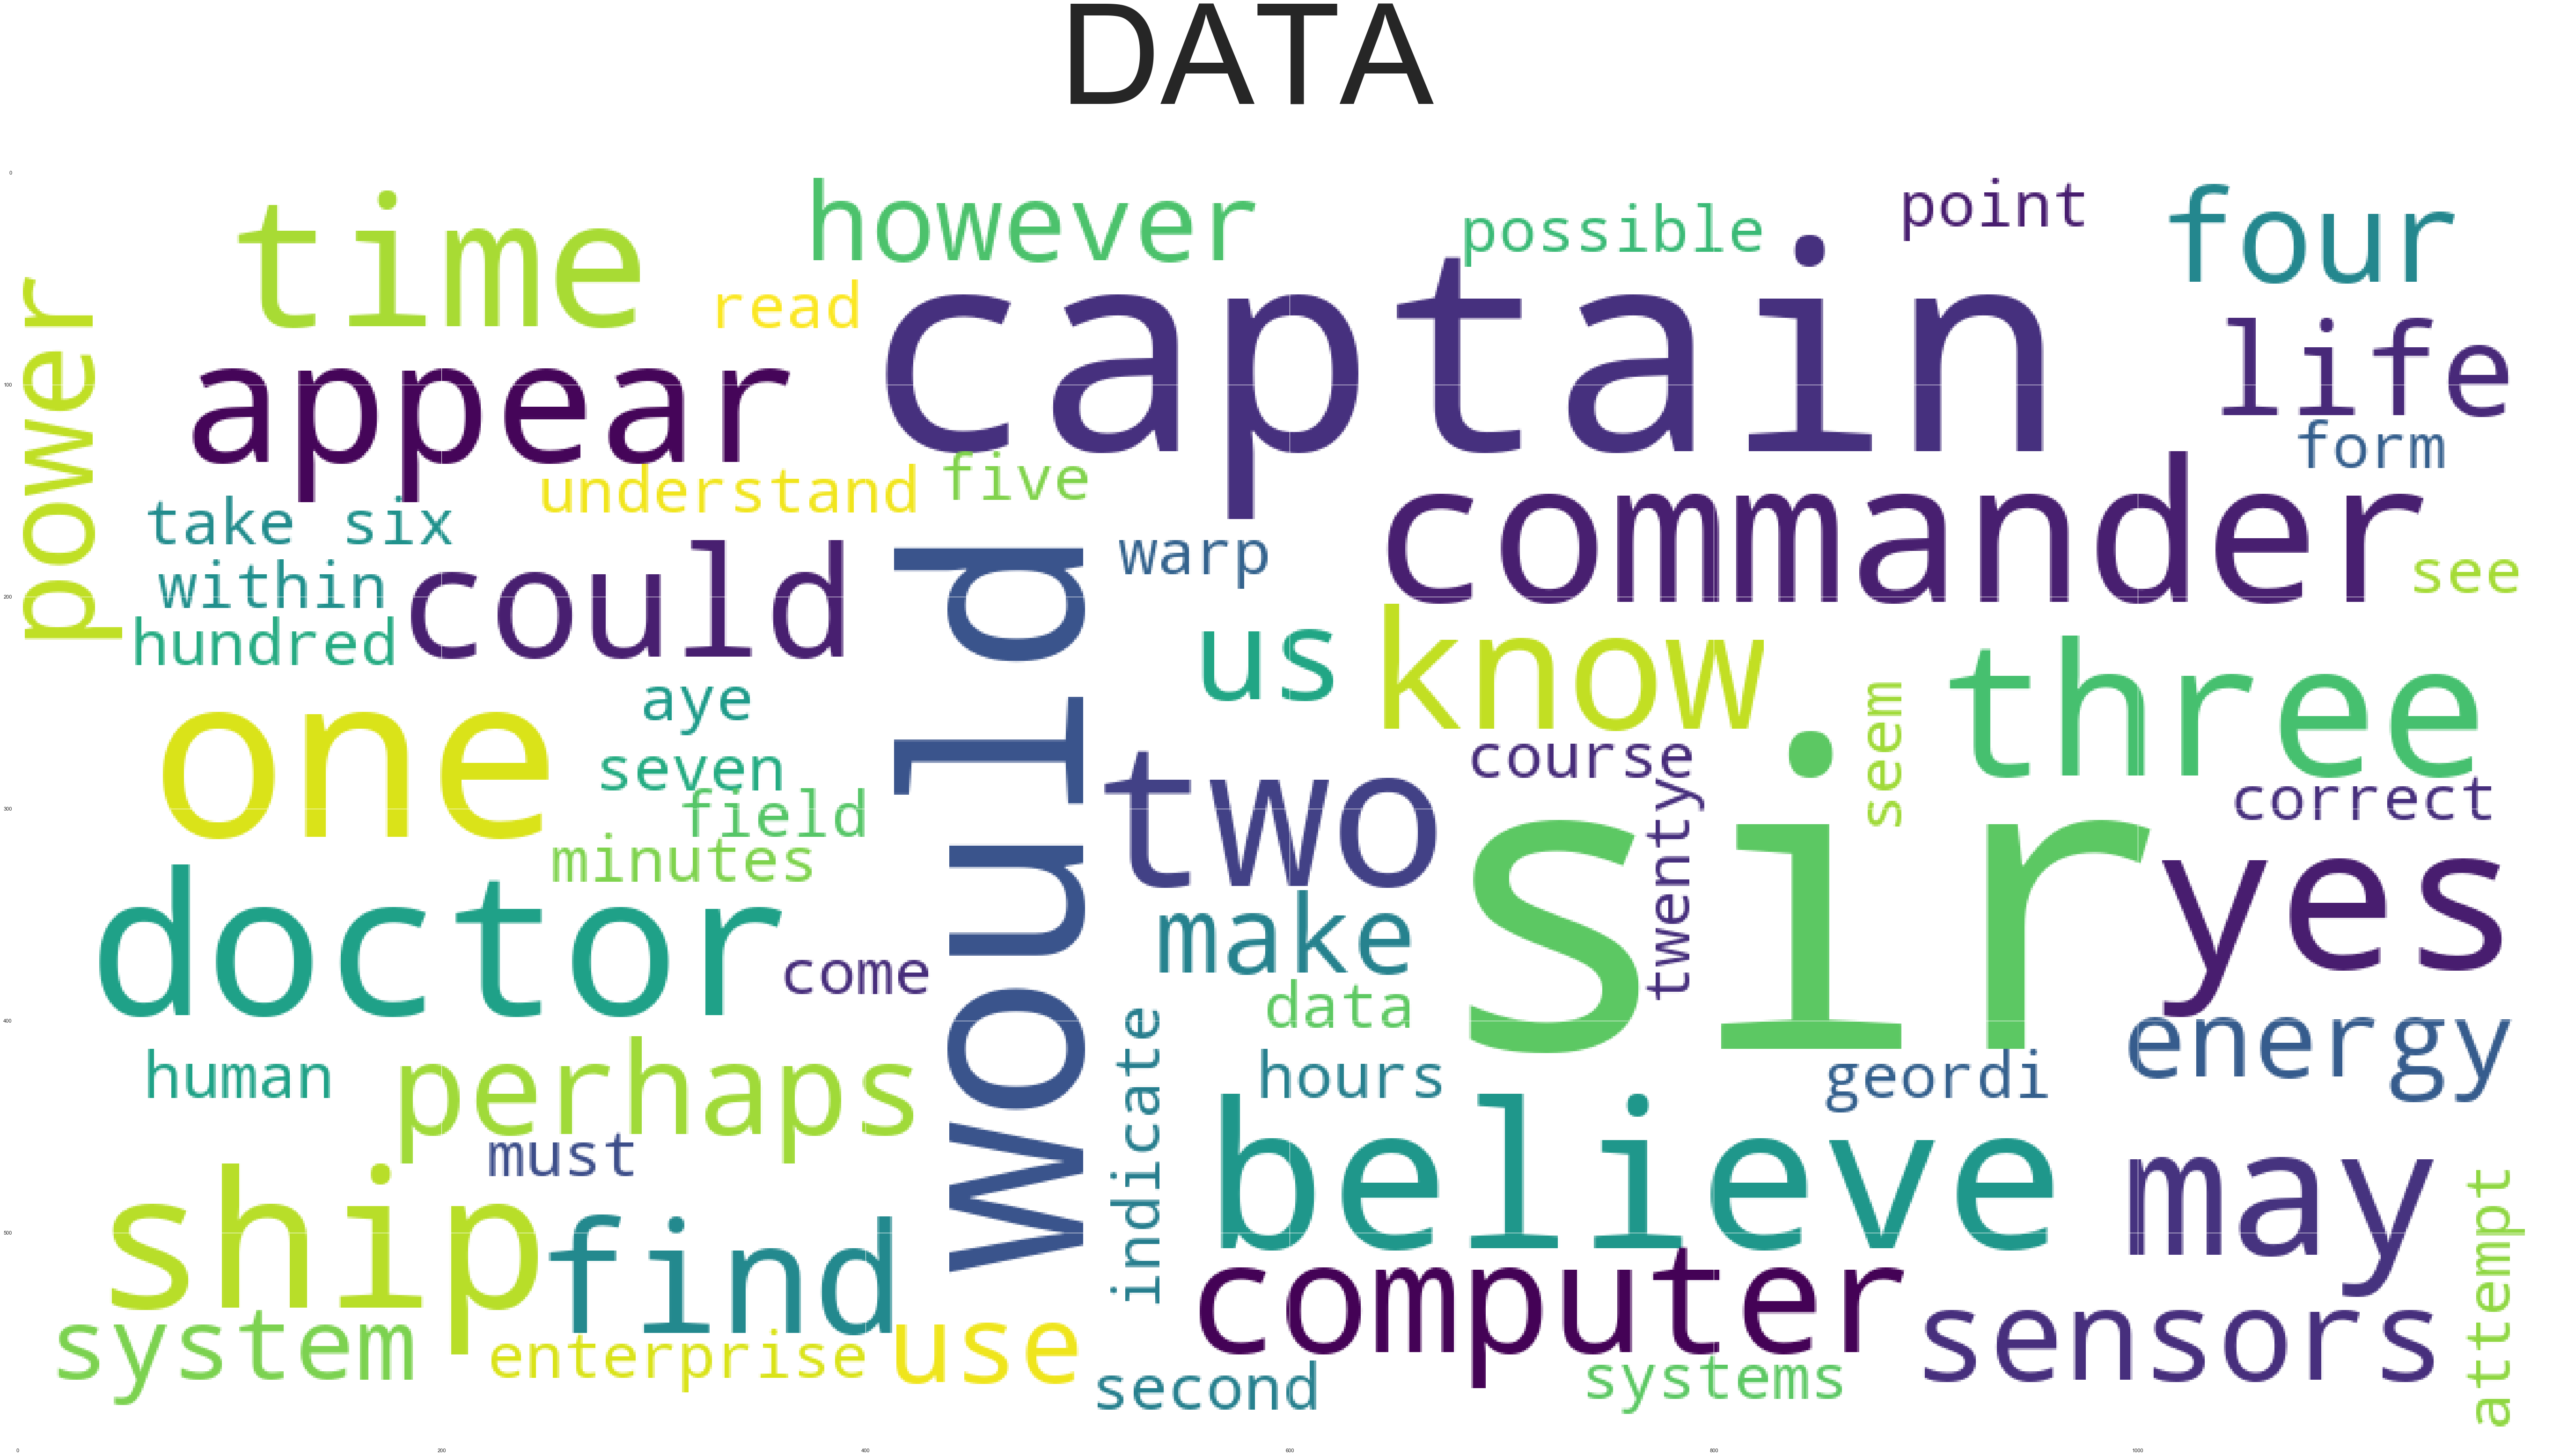

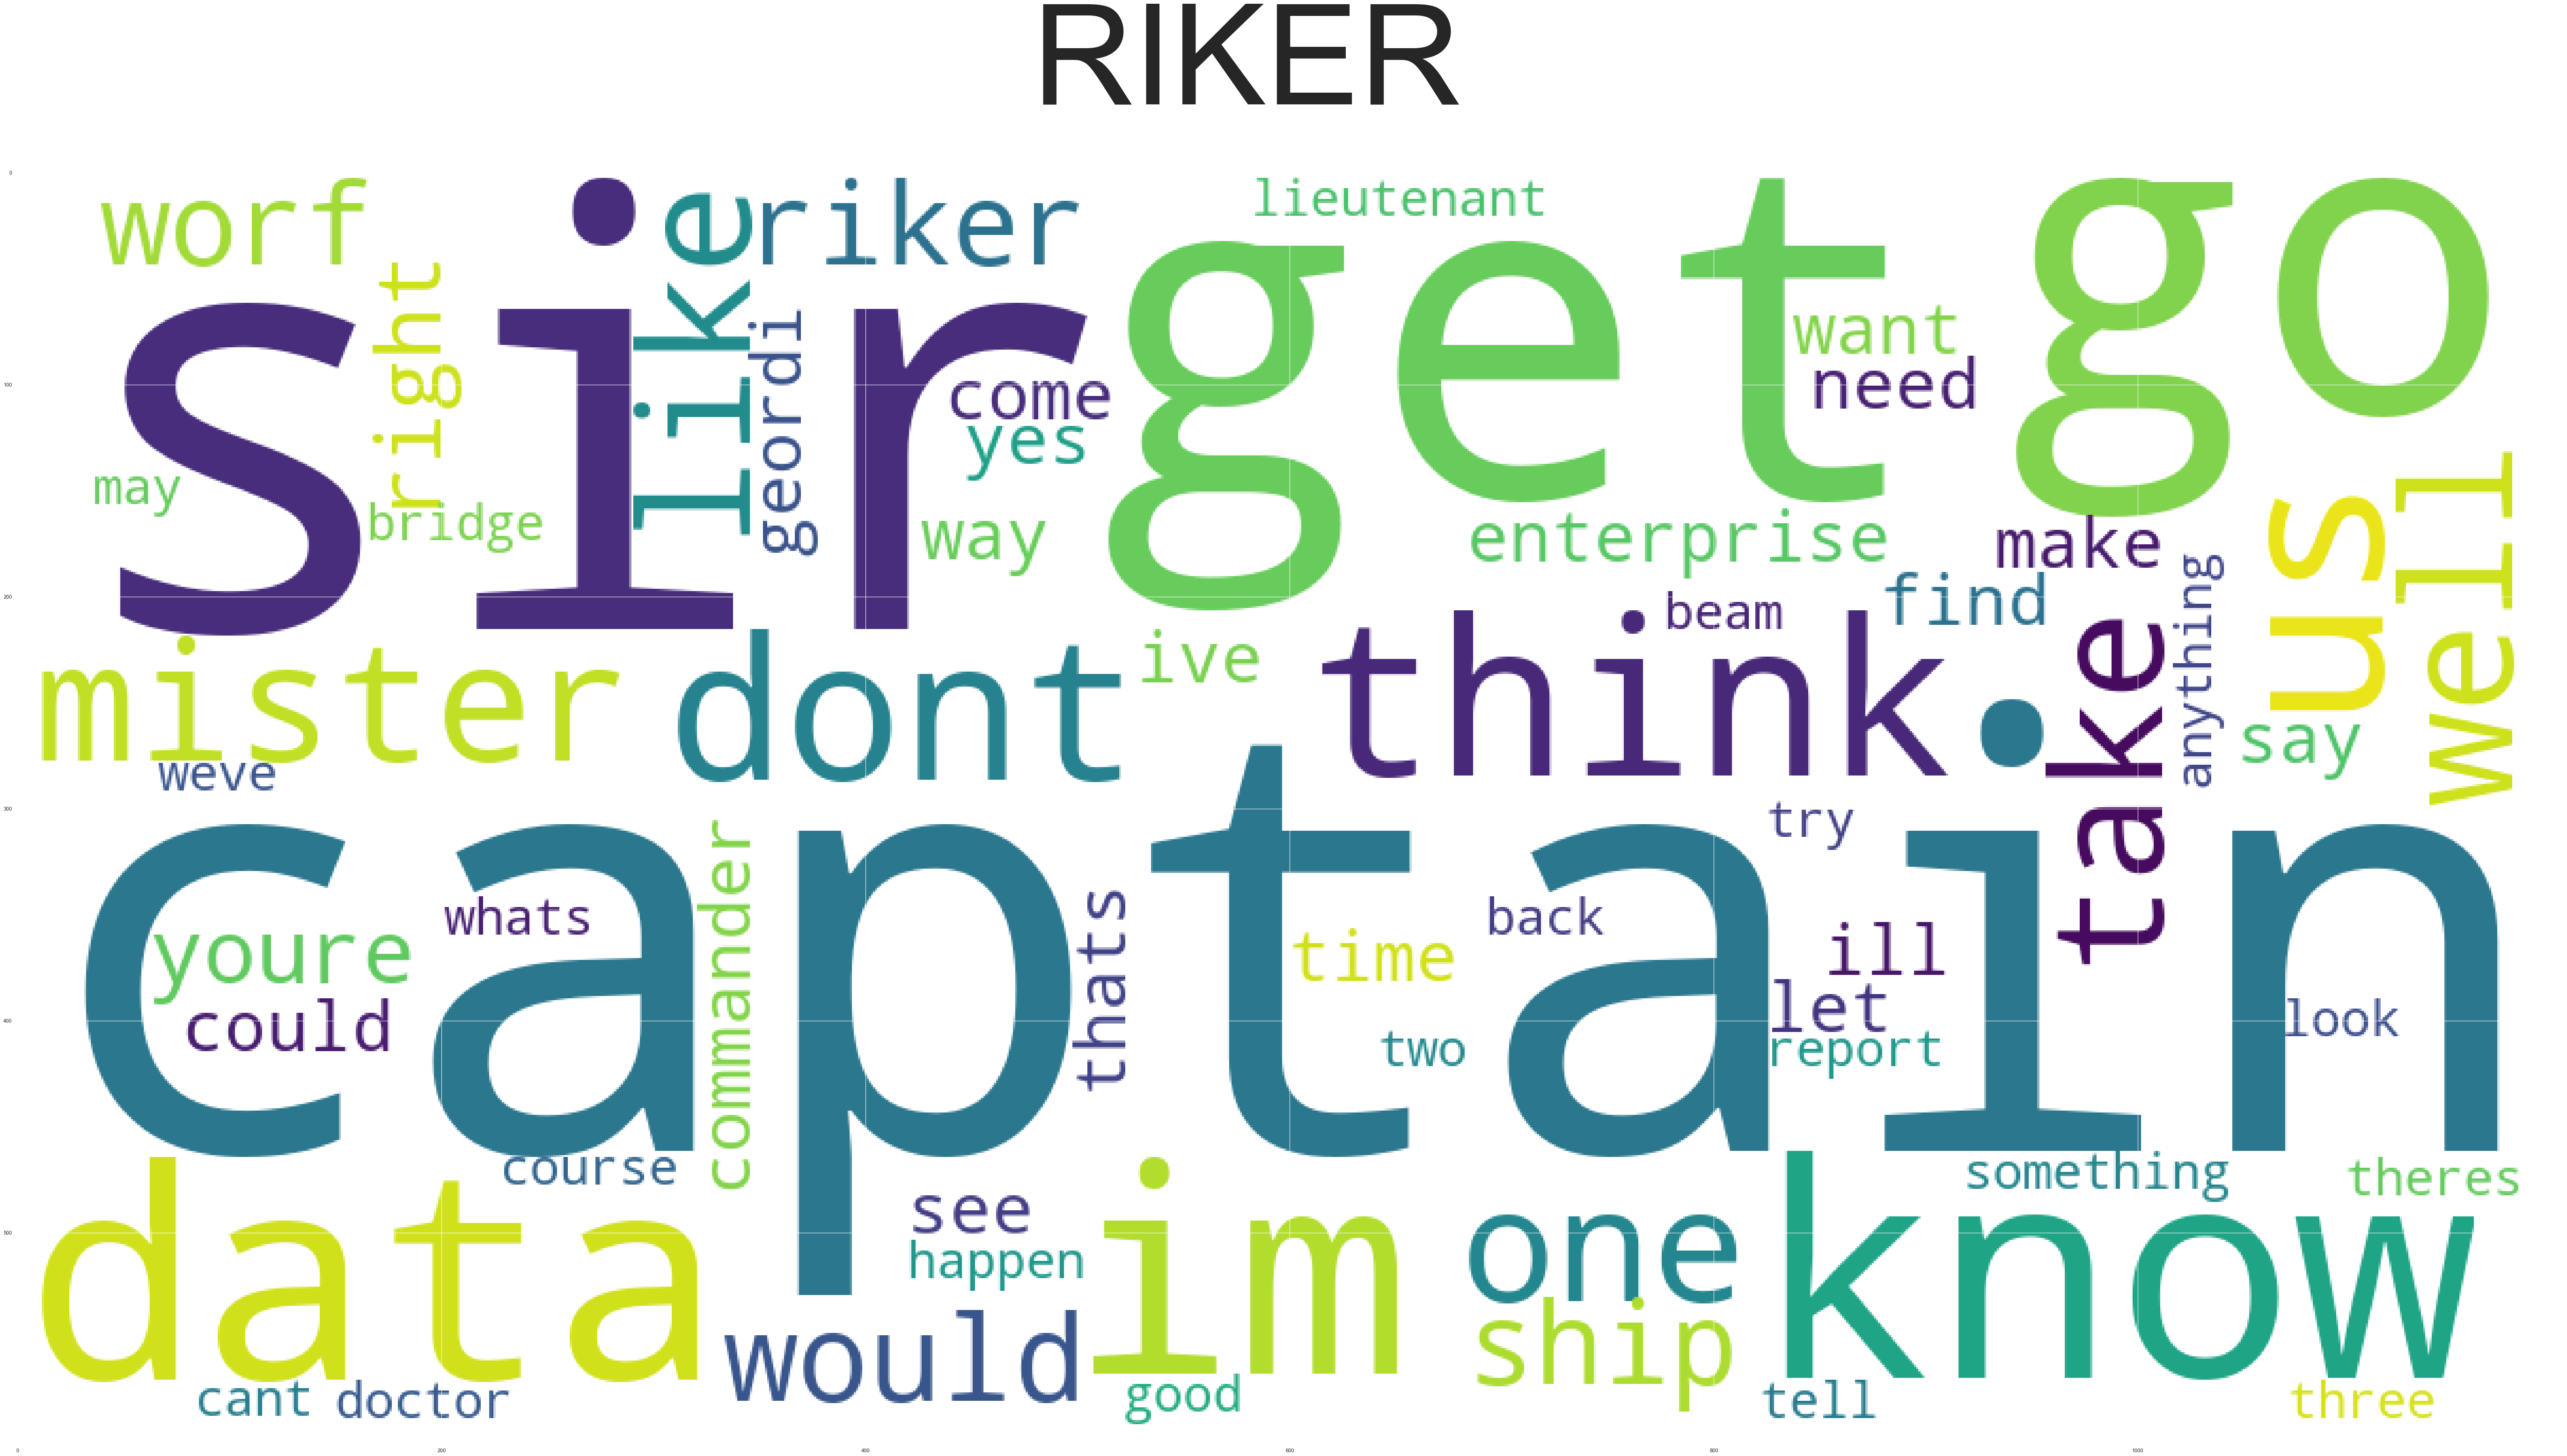

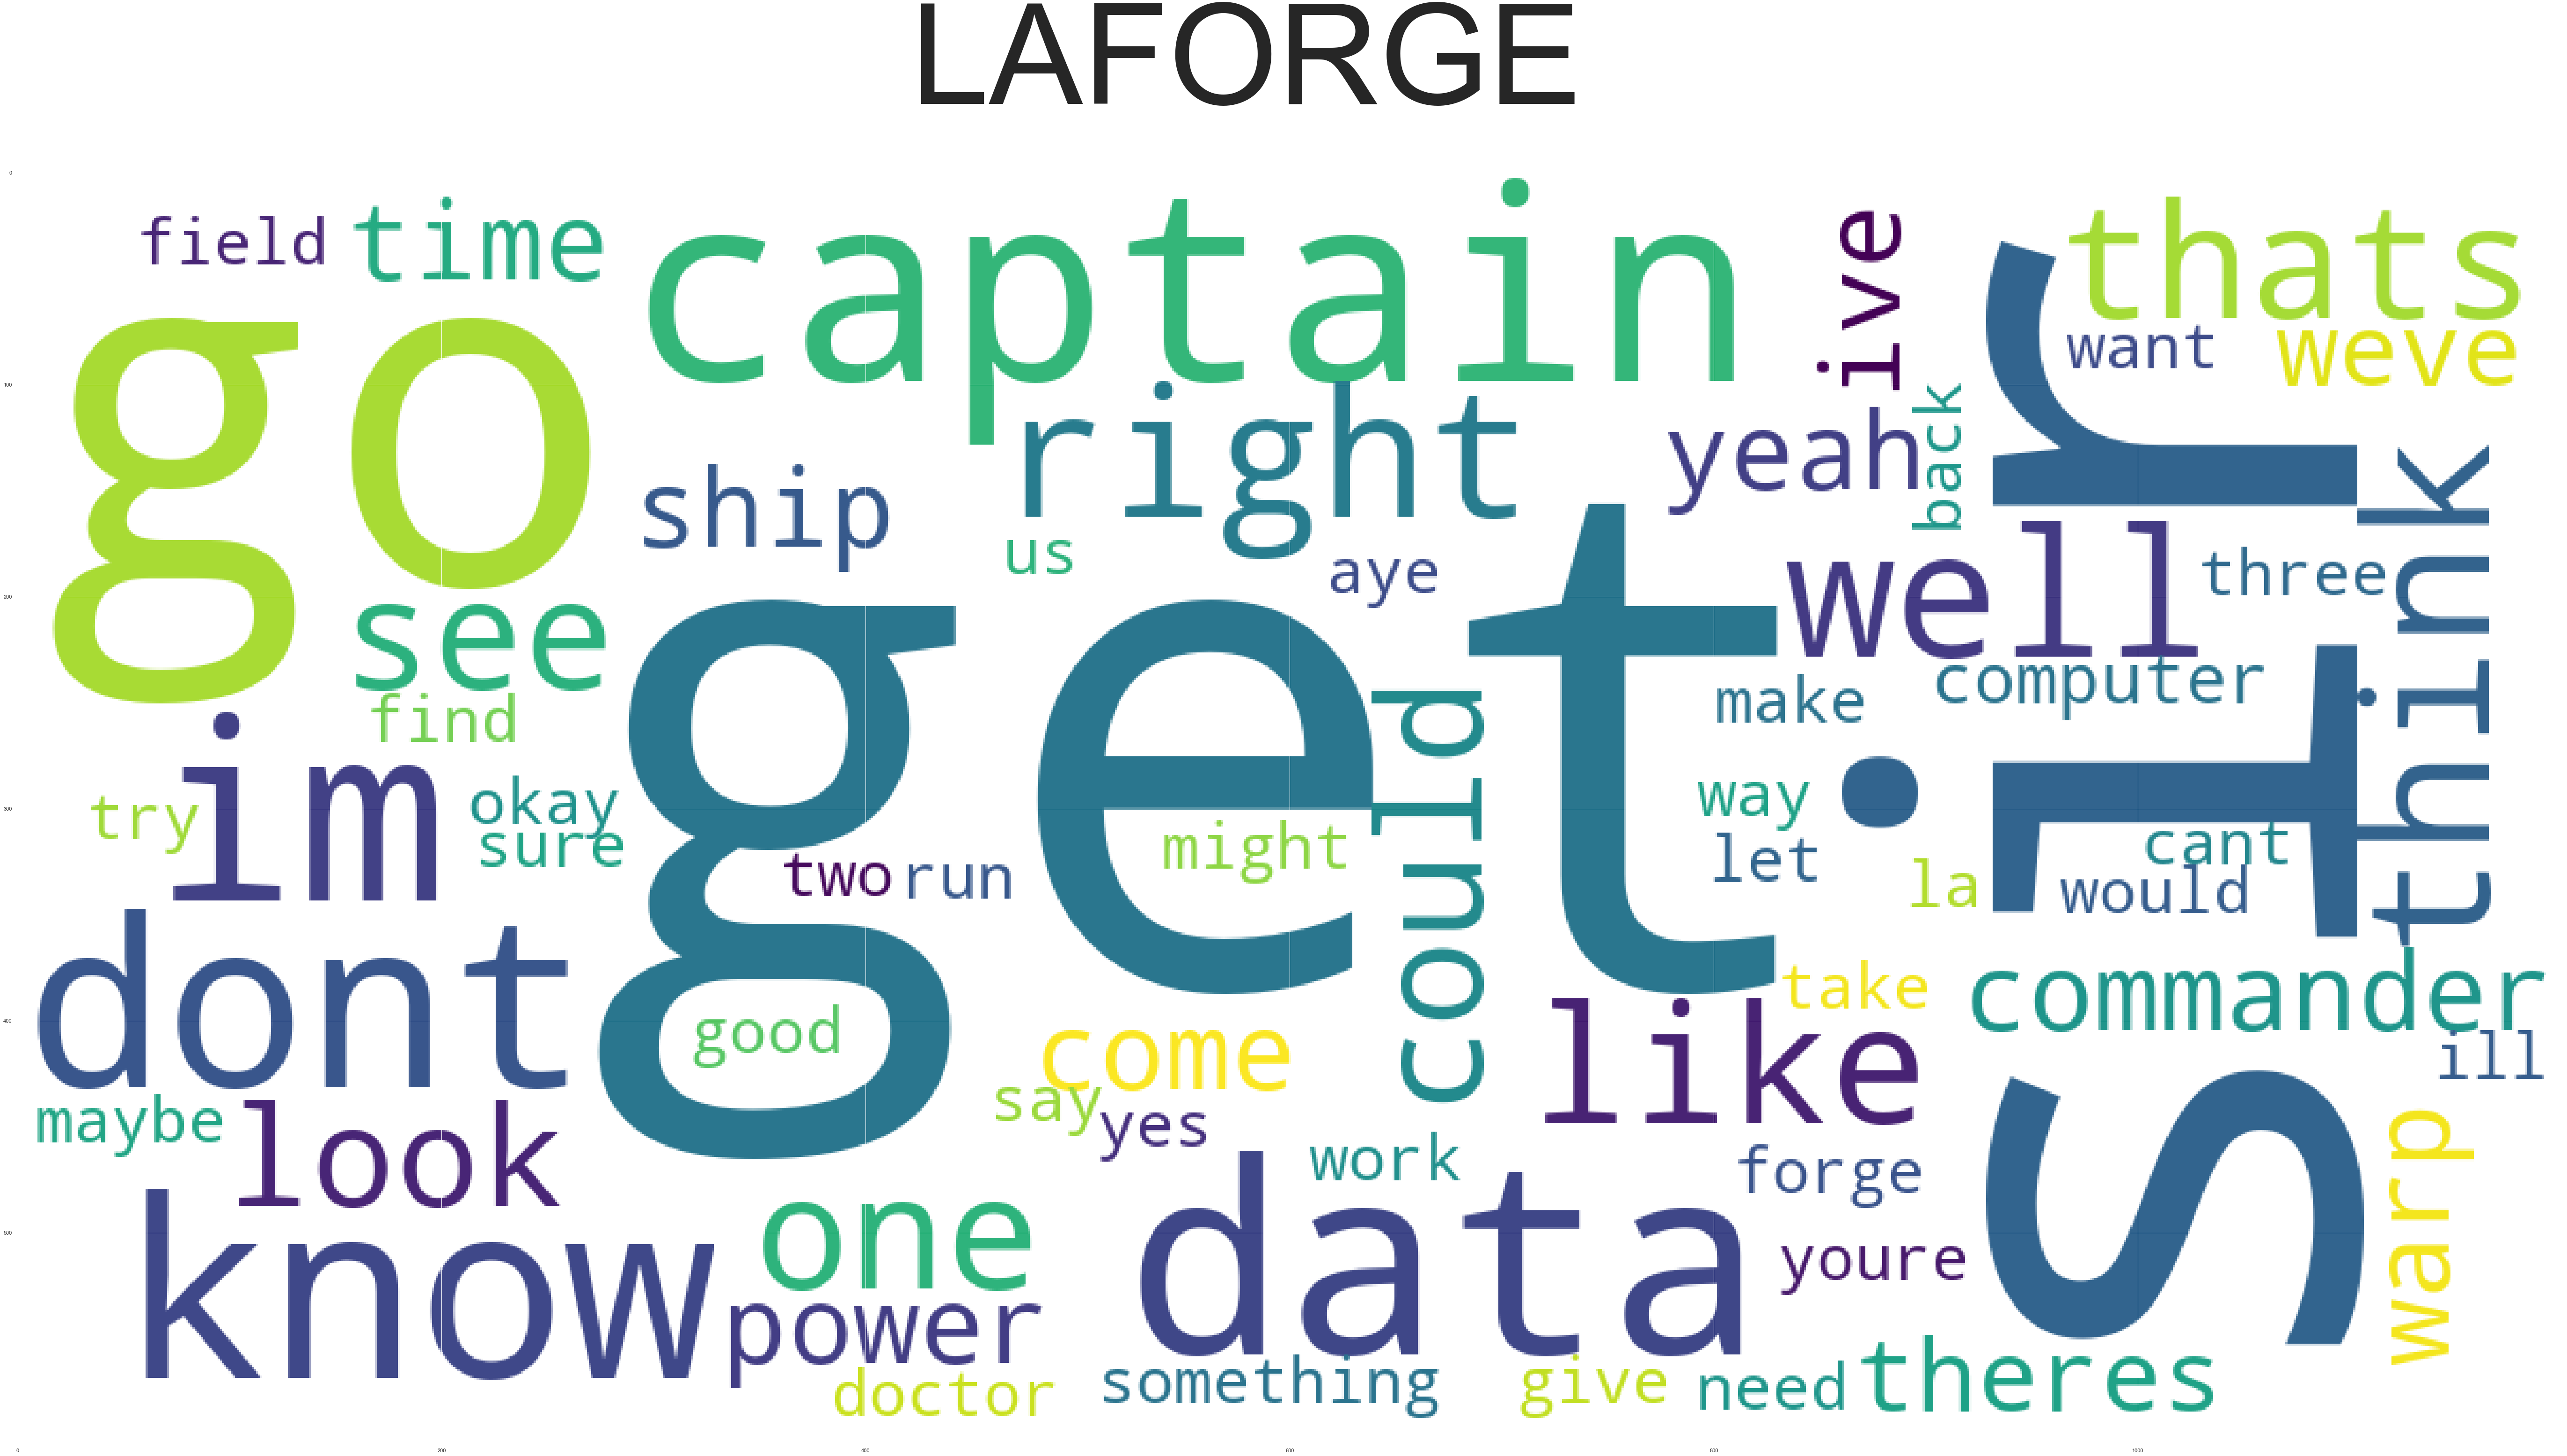

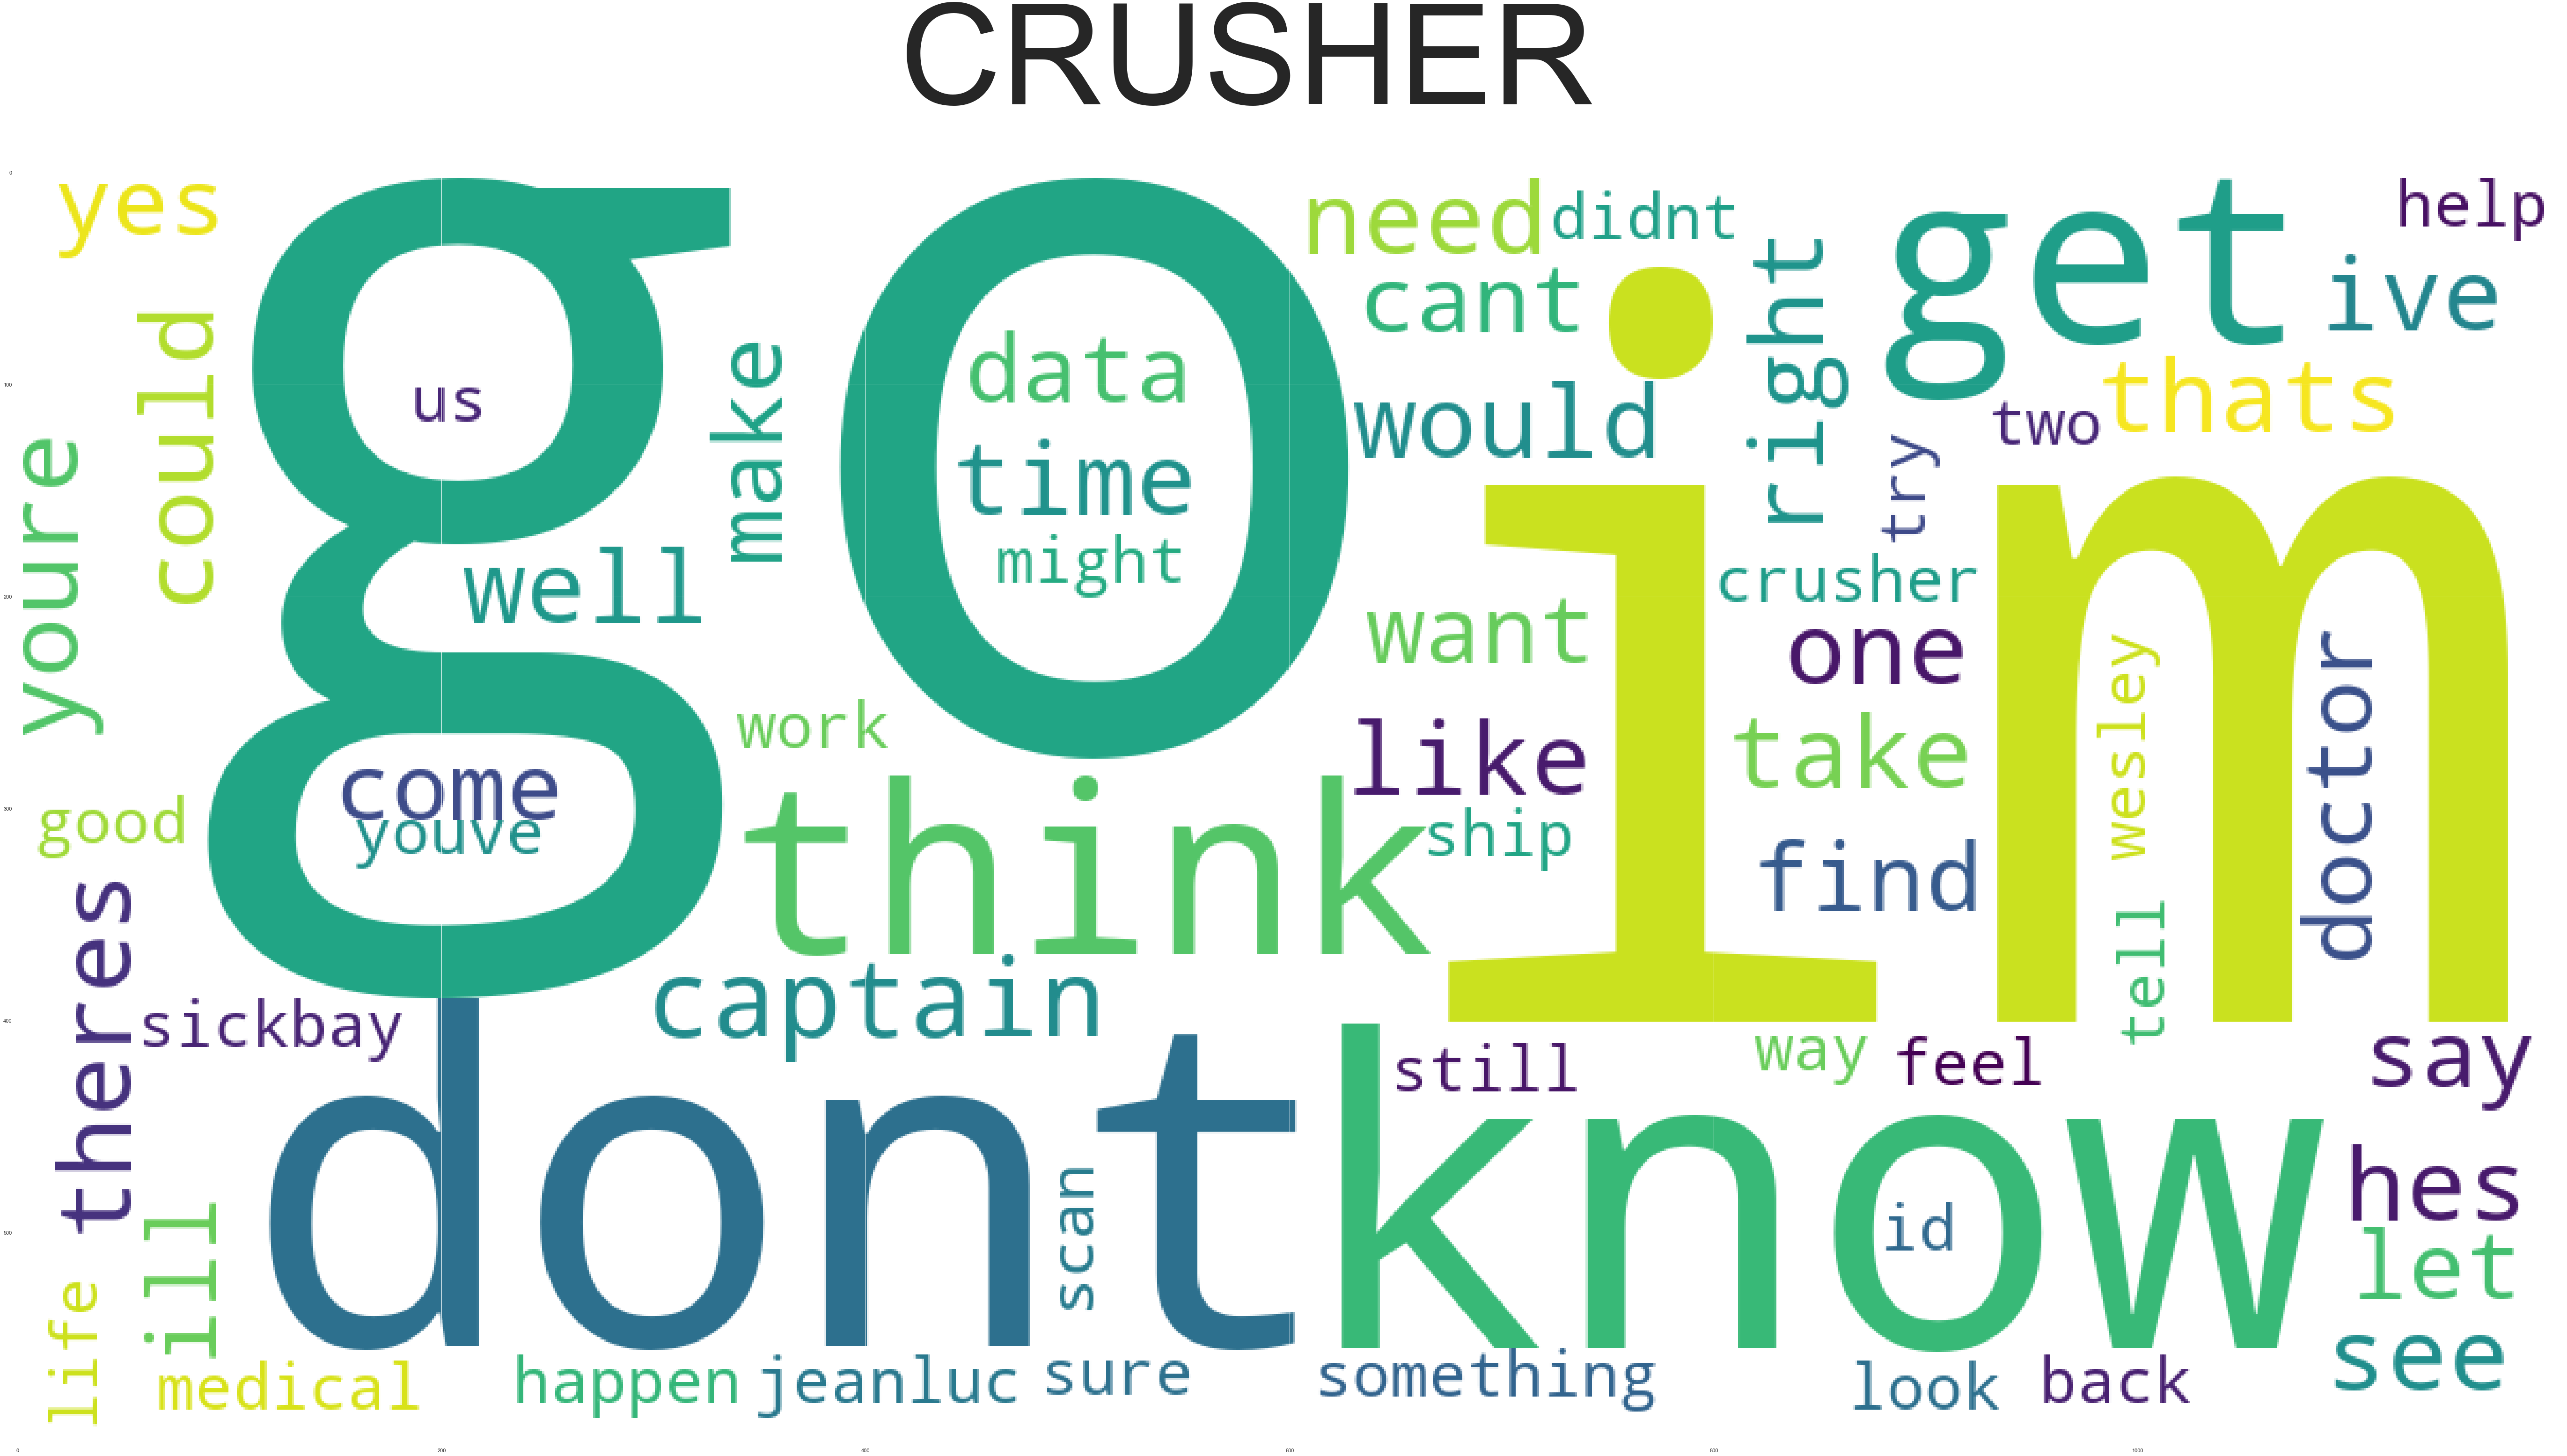

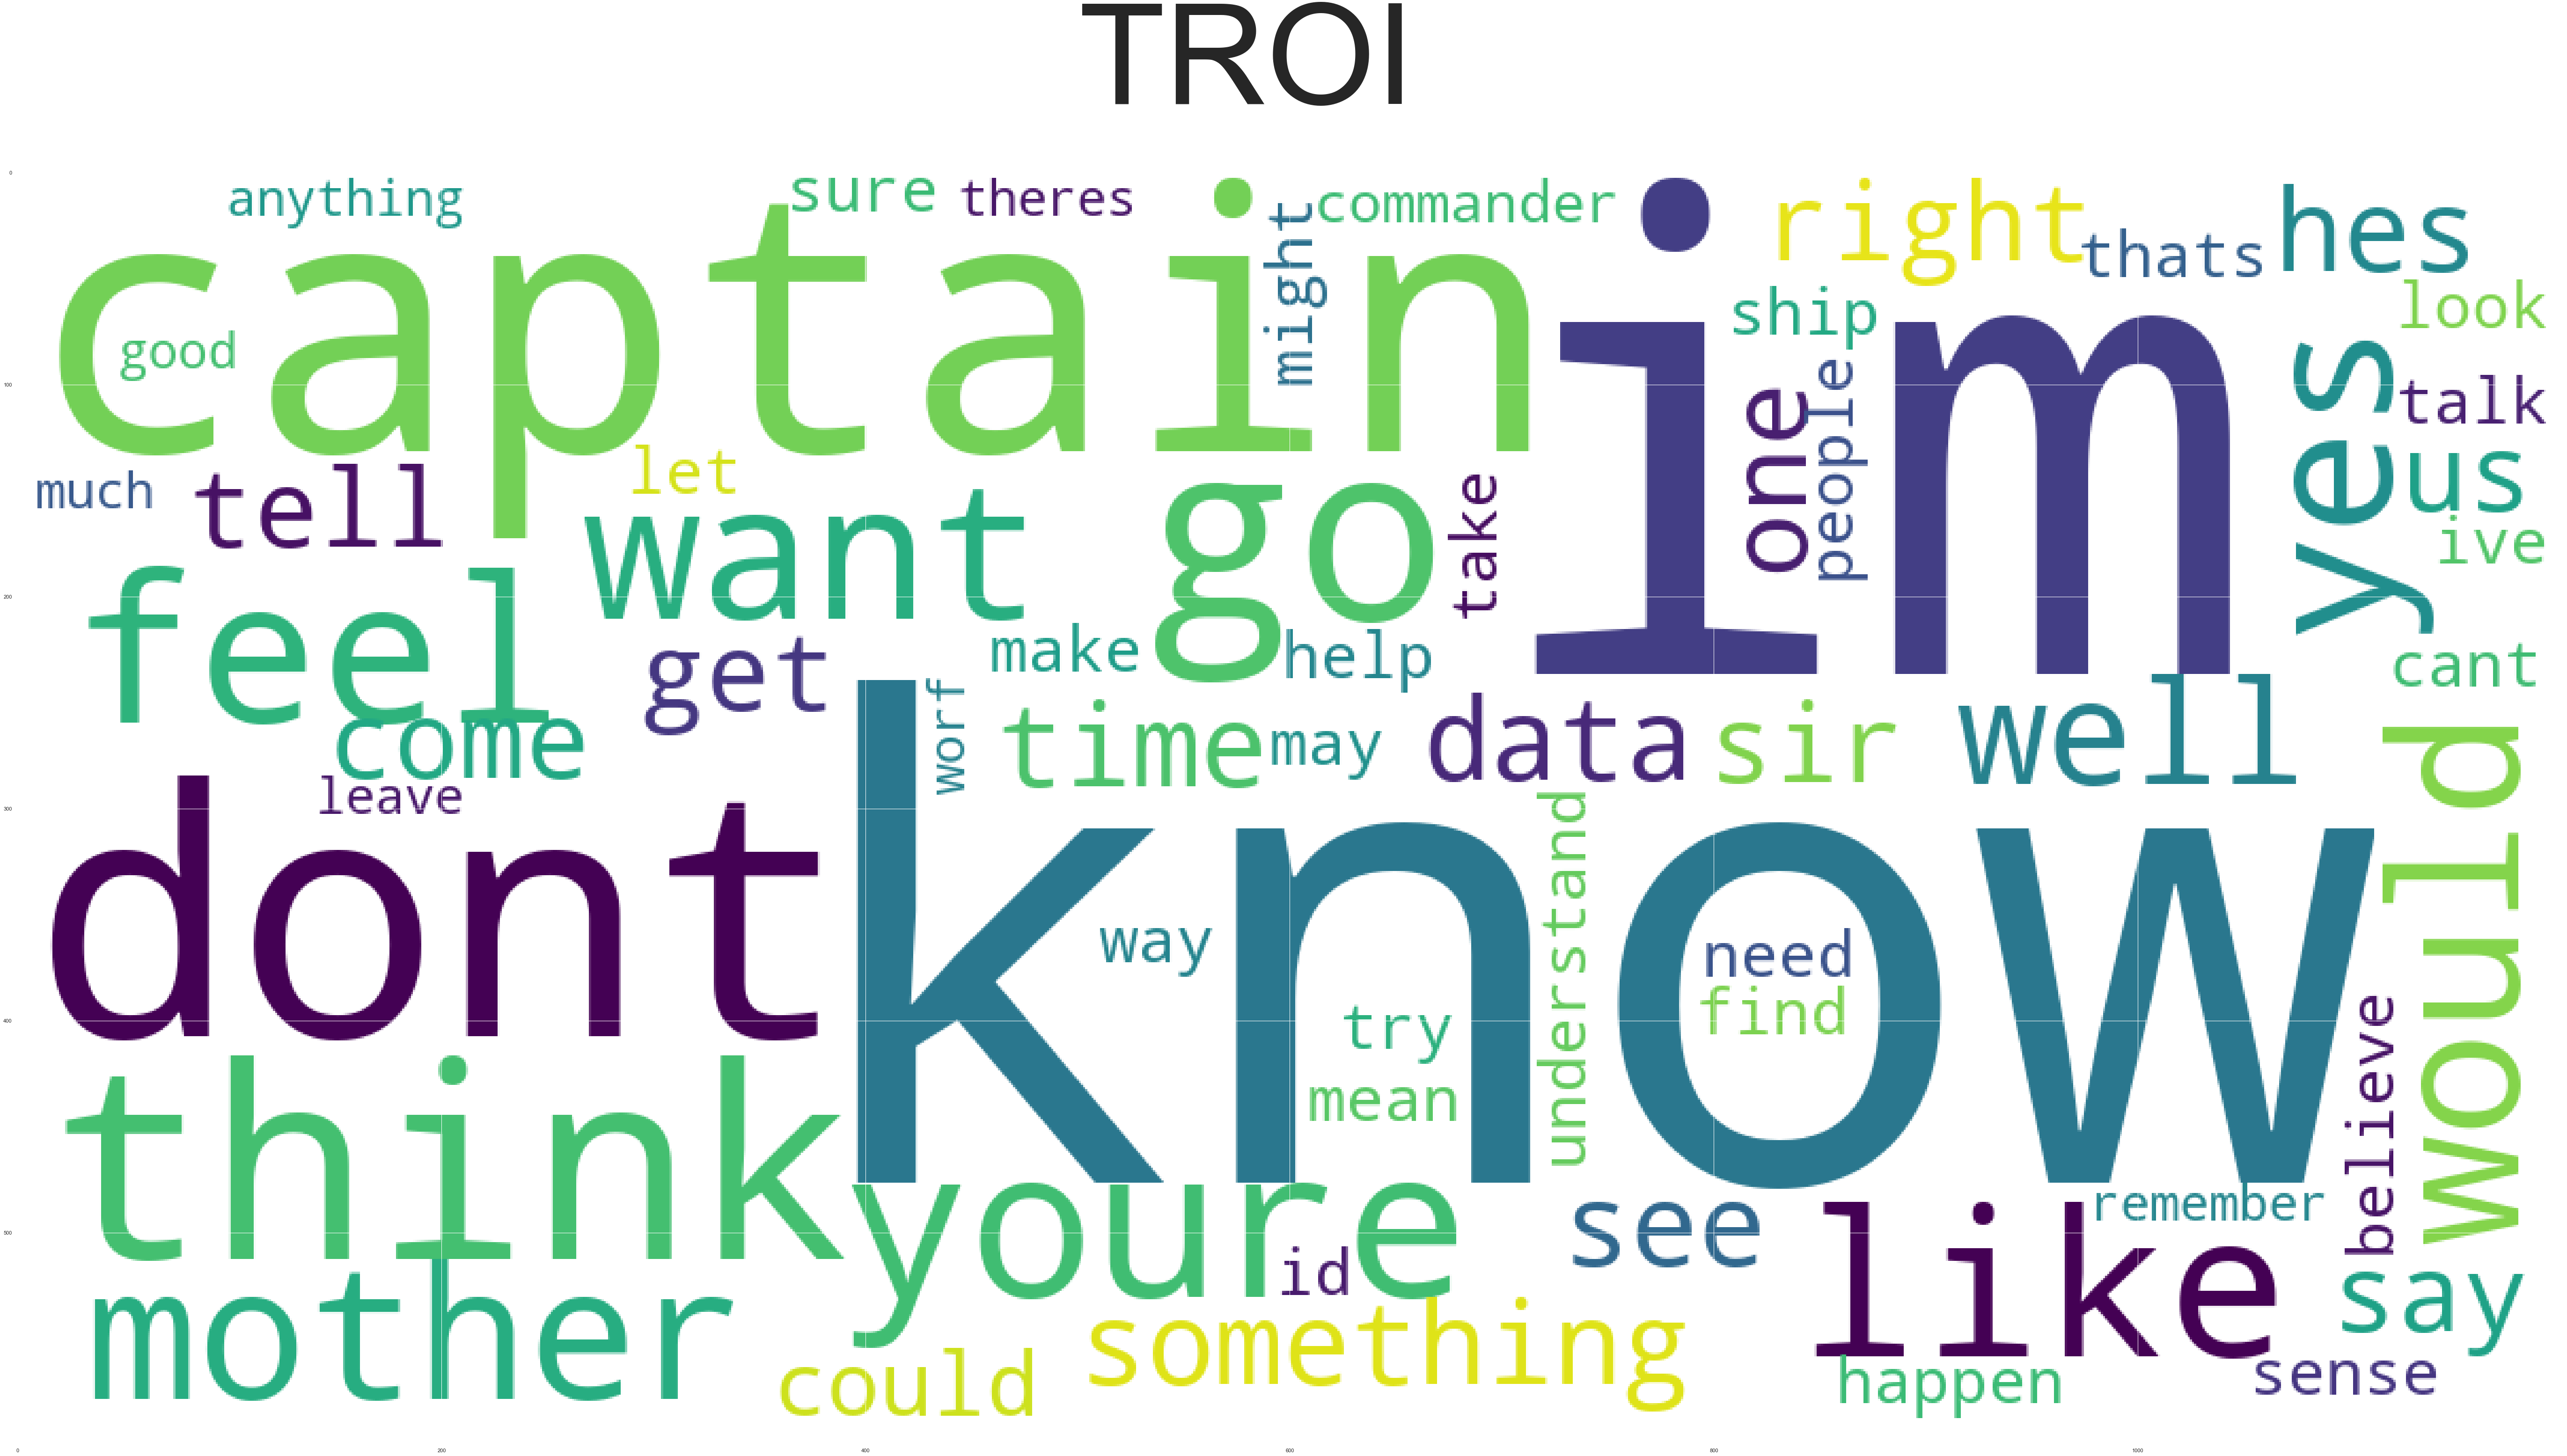

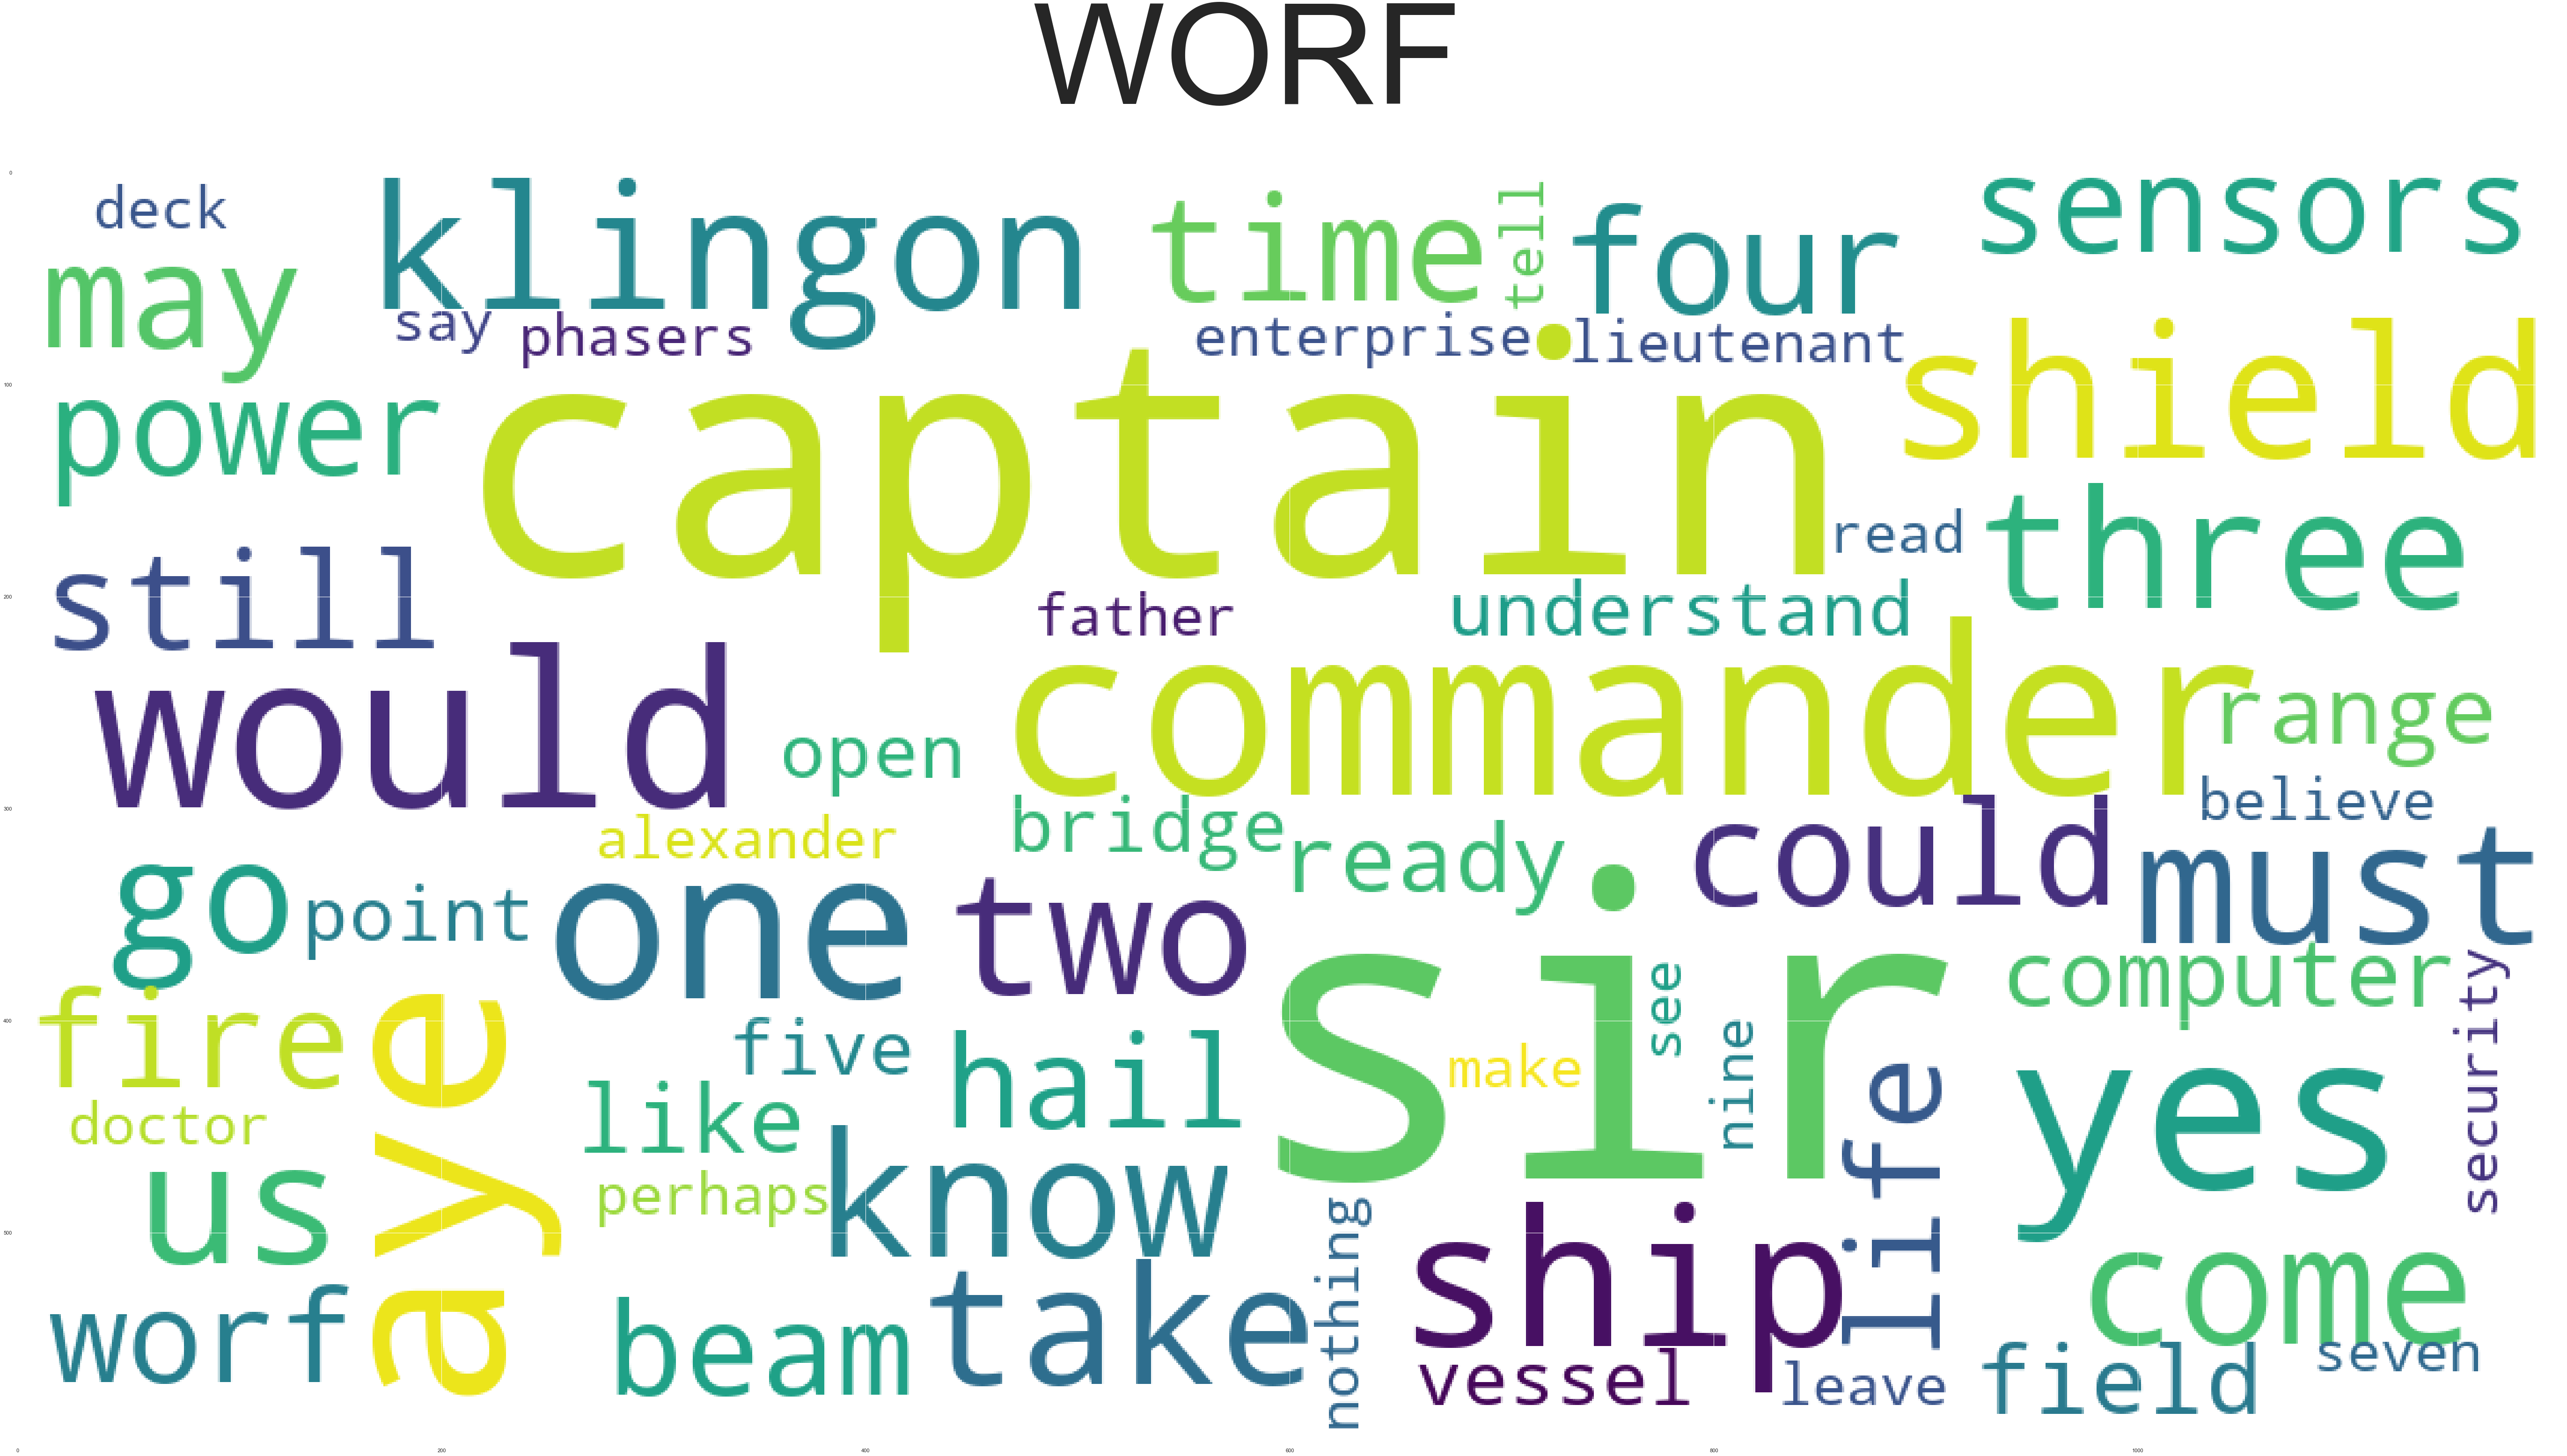

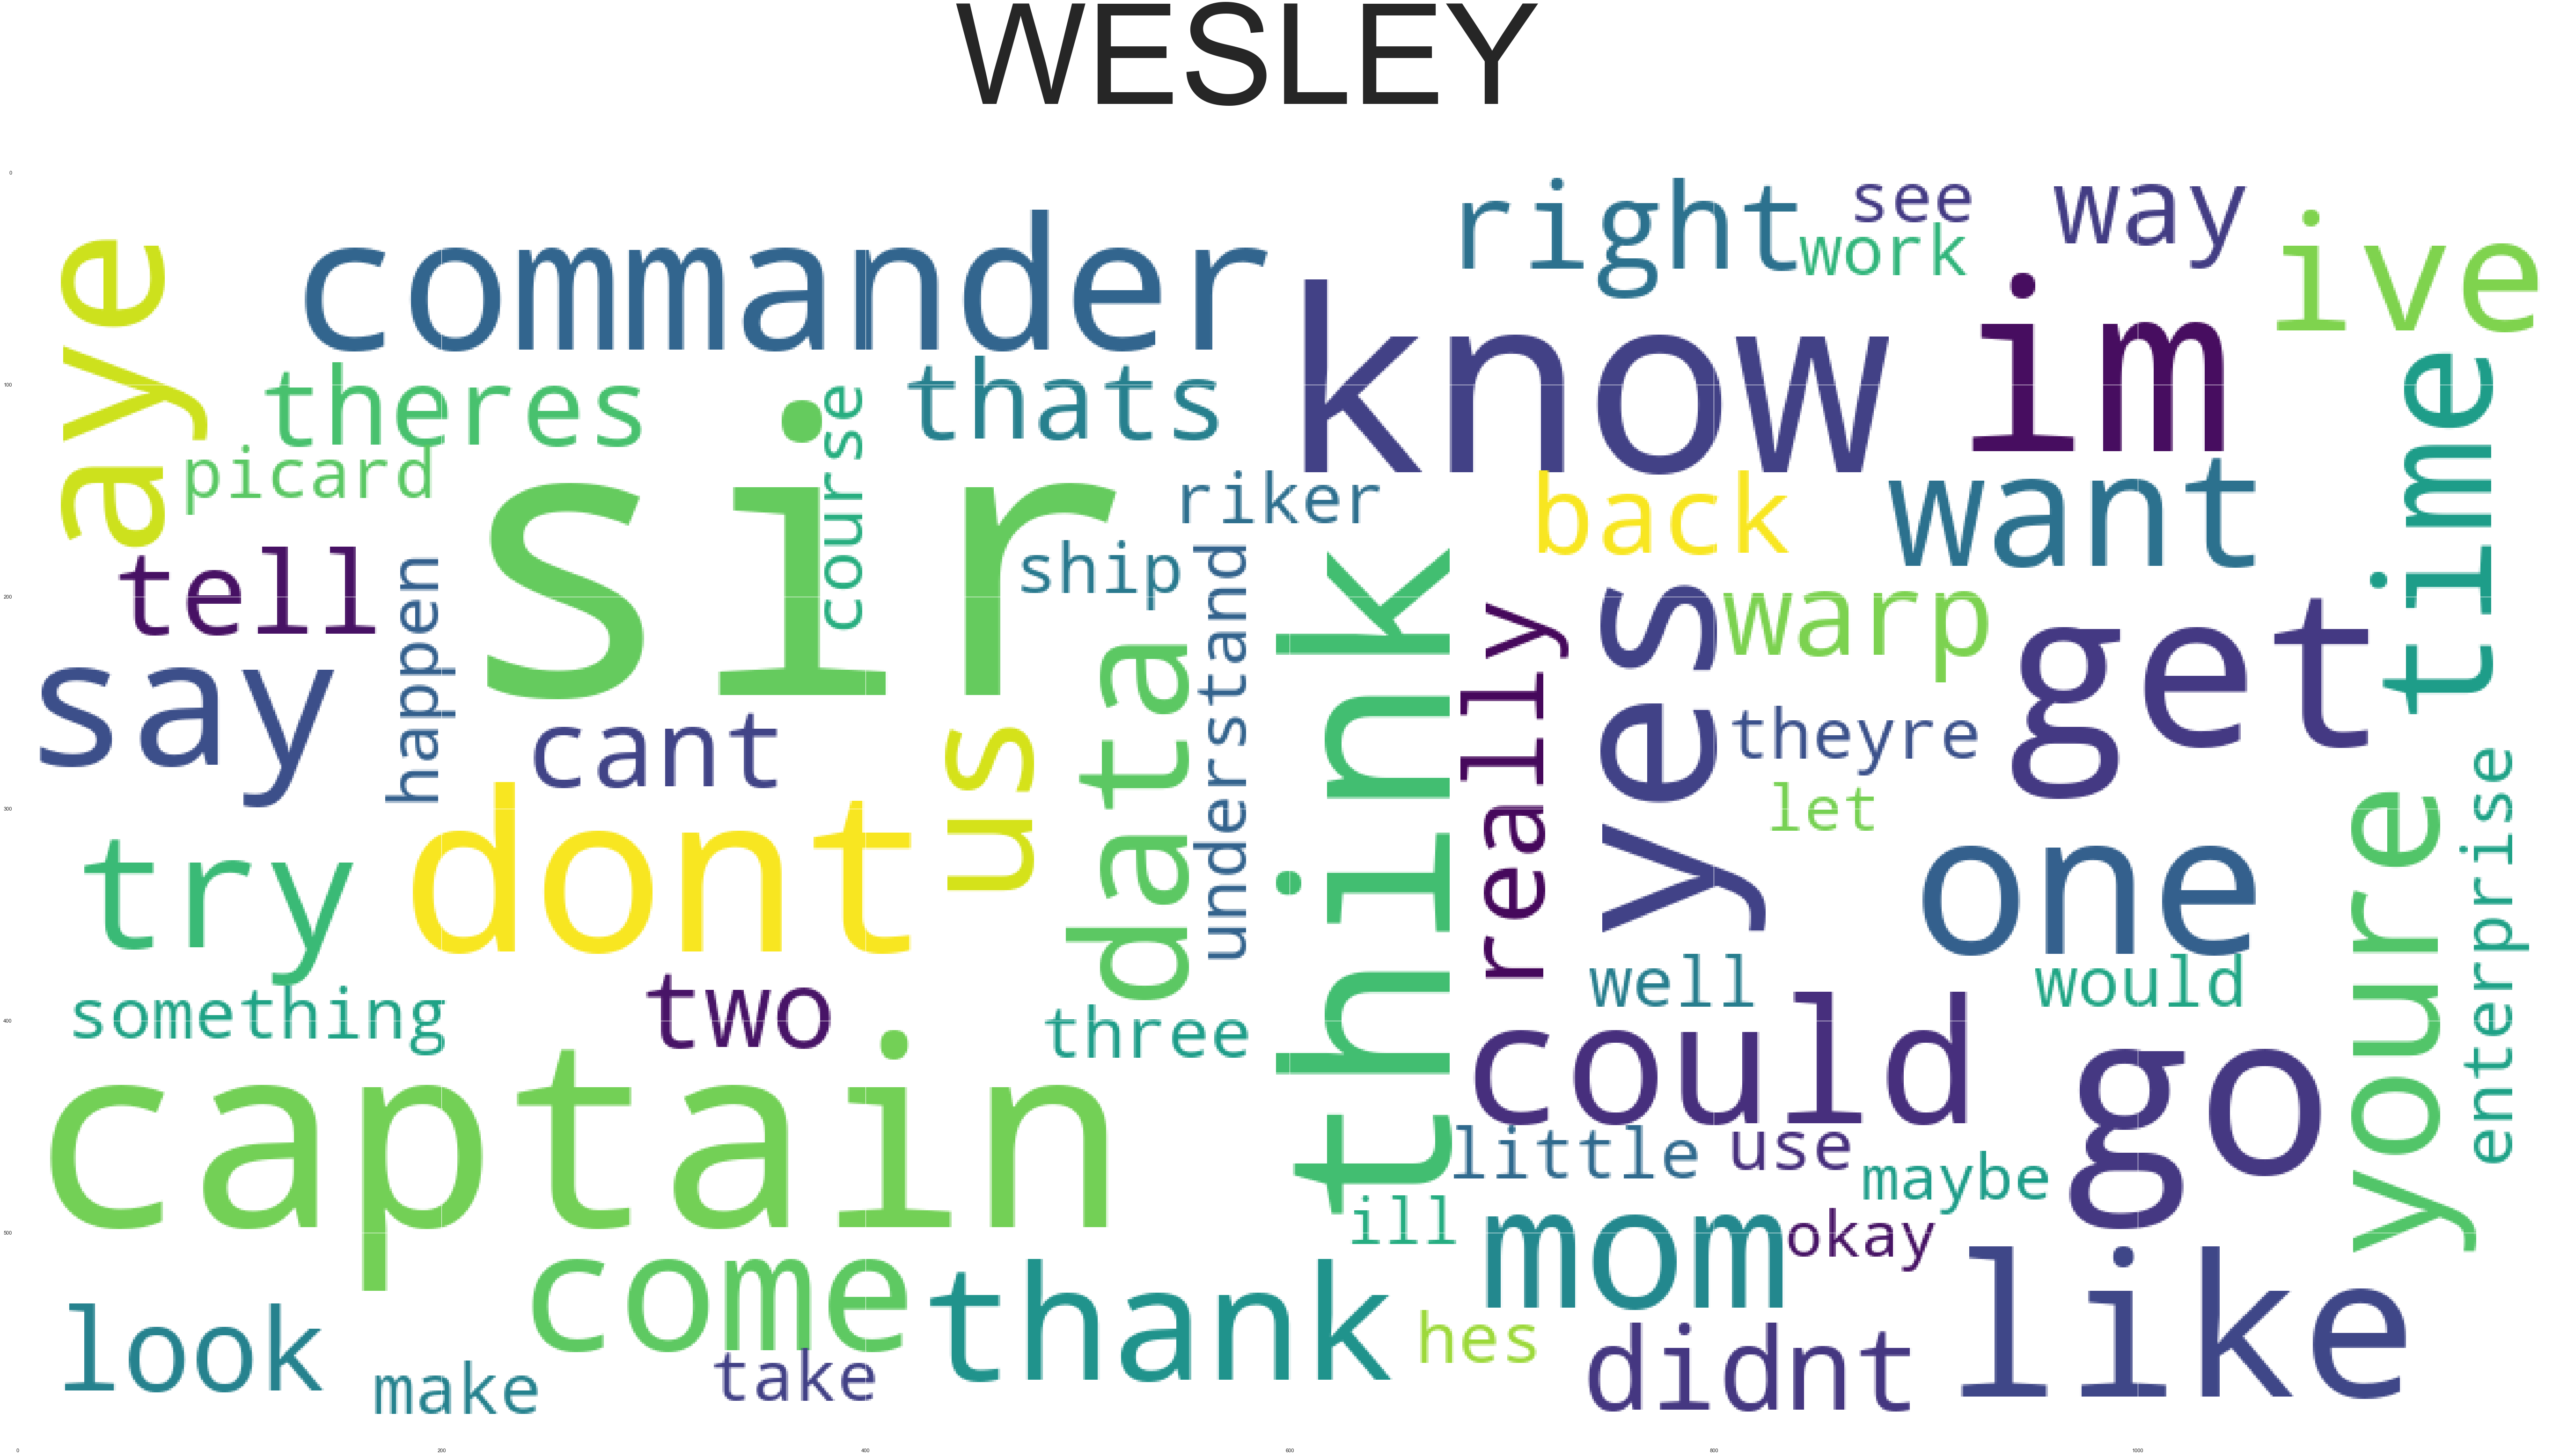

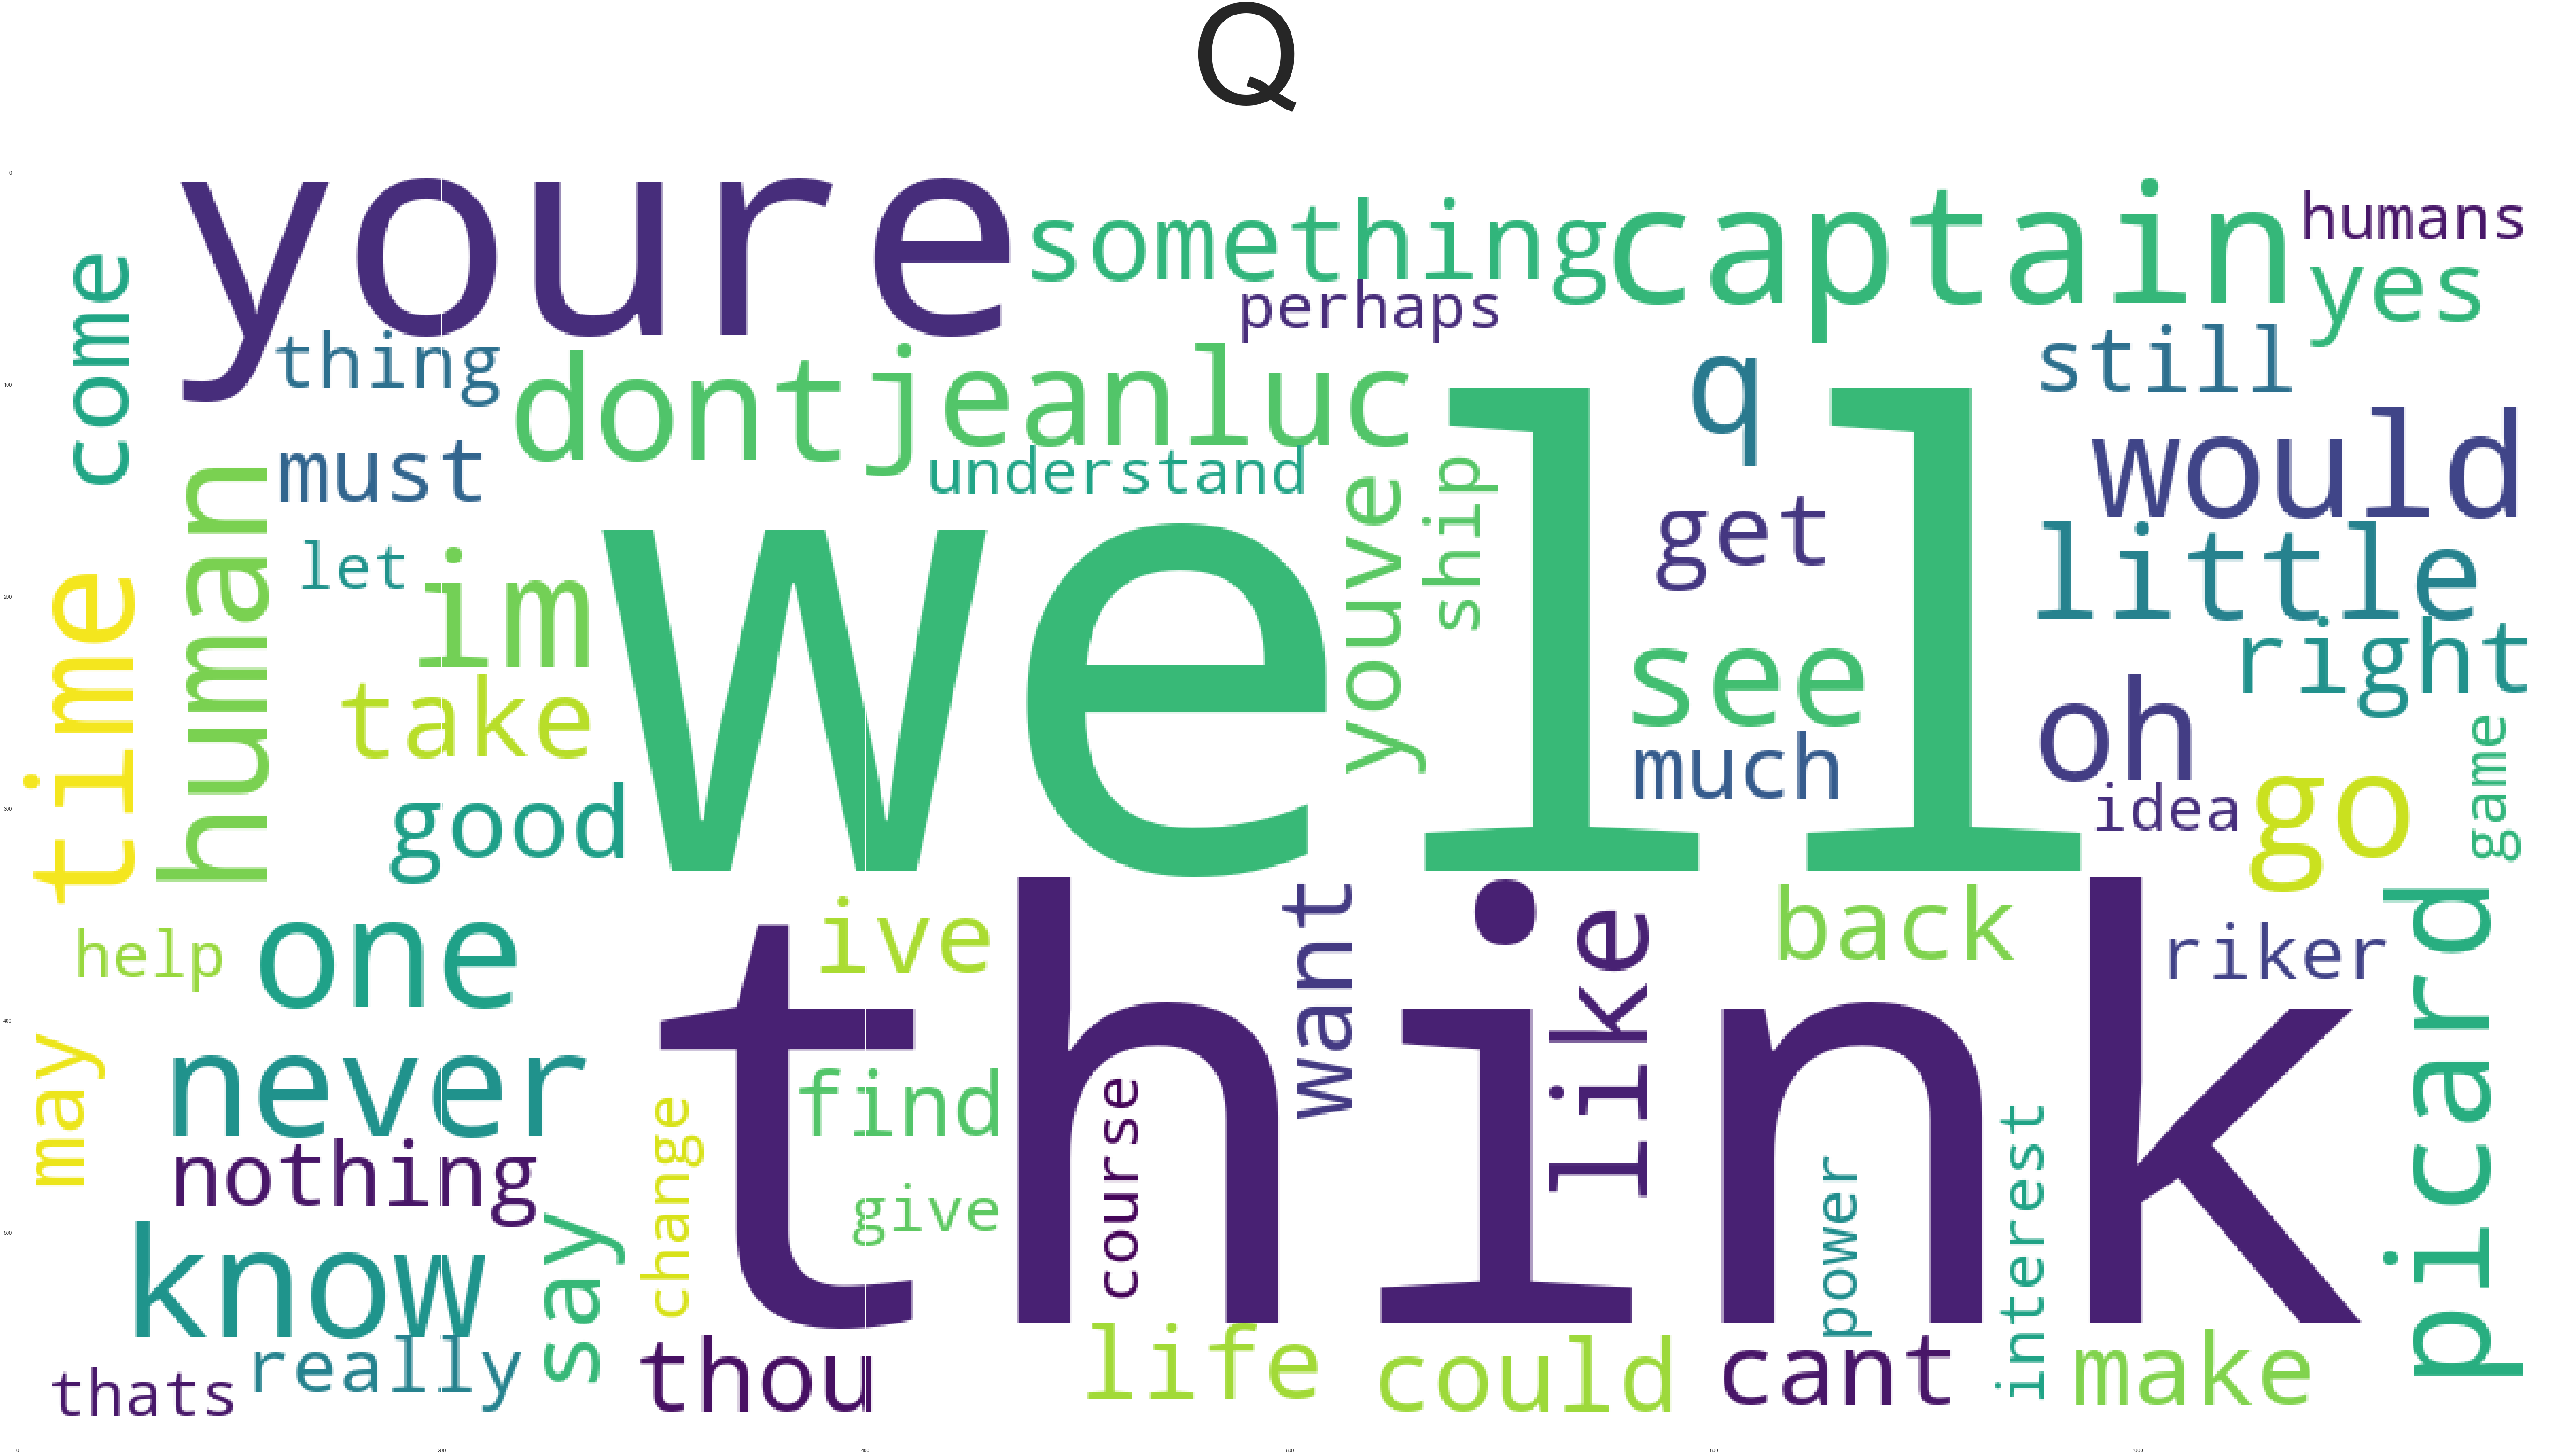

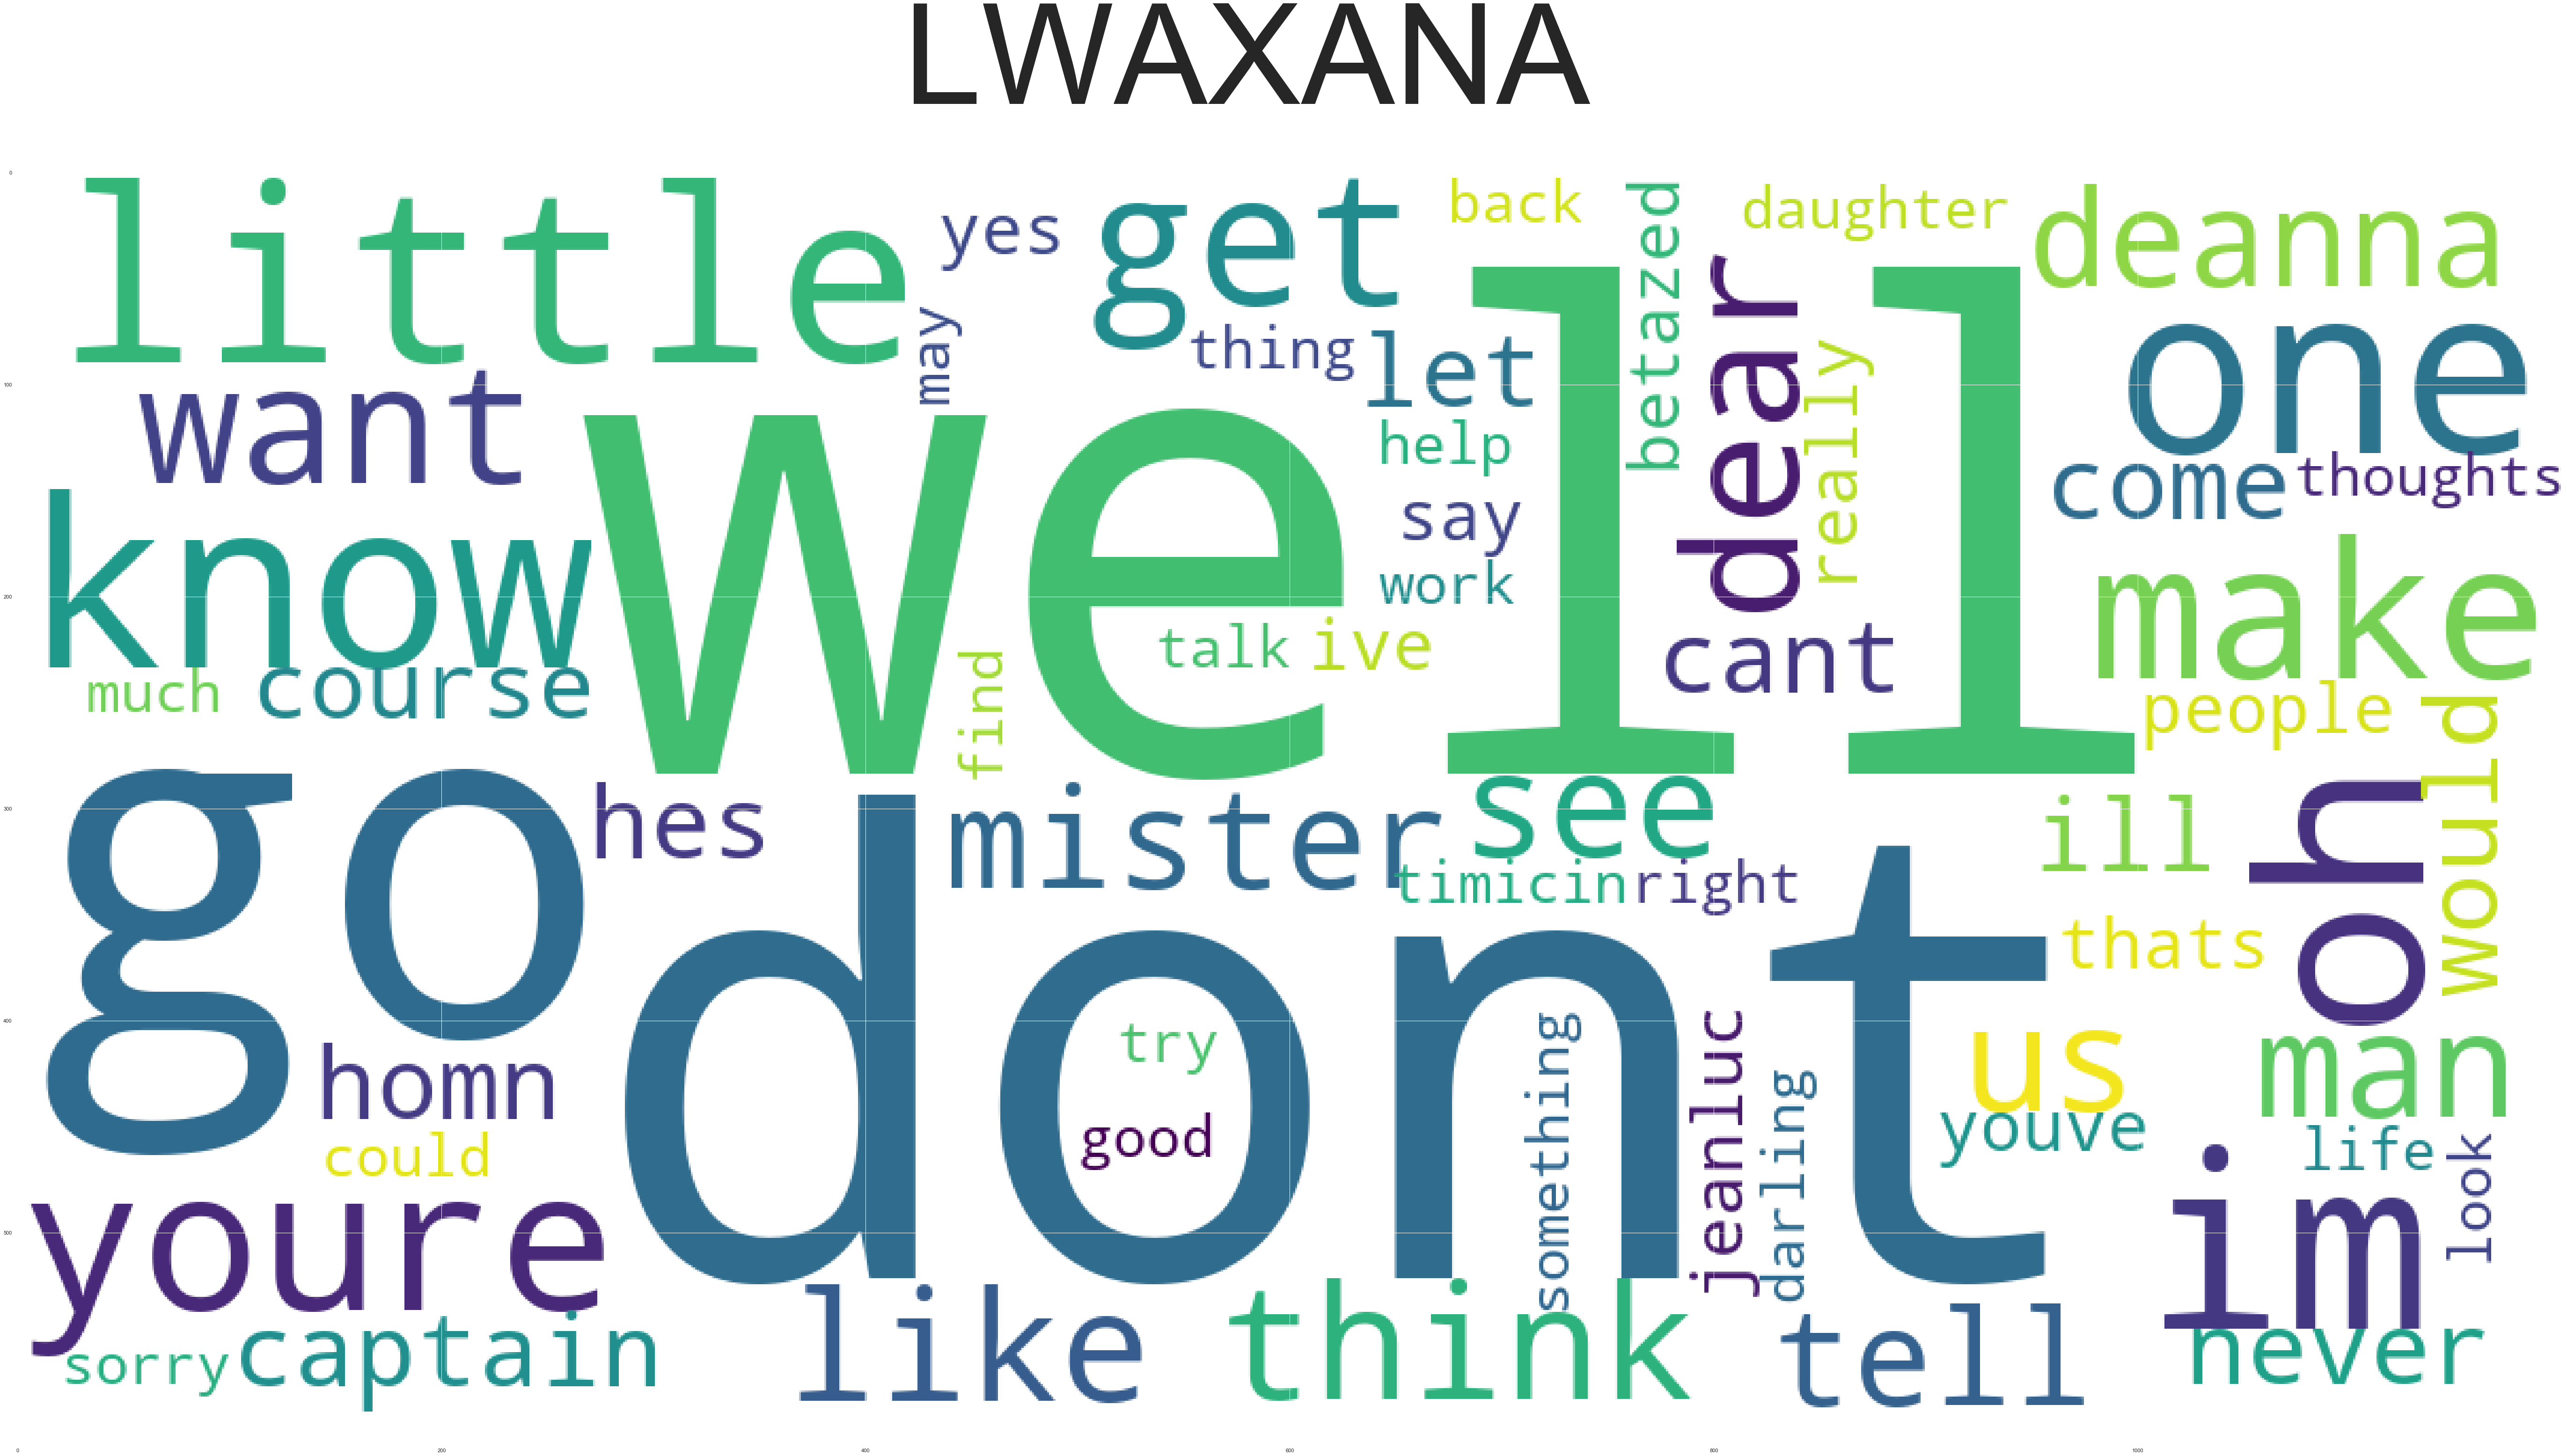

In [88]:
#Now lets plot for our top 5 Characters
for i in j.index[:10]:
    plotter(i)

# Modeling the data

## Creating a network graph between characters 

For this we need to check how many times a character is mention by another character in each dialogue and then count the intereactions.

In order to accomplish such goal, which is not given by the dialogue text I had access to I just created a new column called 'to' and put it the character name that was in the next row, as most of the time that dialogue was intended for the next character. Of course is not accuarate but it is the best approximation I could get, the final results are also pretty good

In [33]:
# Use pythons shift function to get the next element in the Character series
df['to'] = df.Character.shift(-1)

In [34]:
df.fillna('None', inplace=True)

In [35]:
def create(x):
    return x['Character'] + " , " + x['to'] + " , " + x['dialogue']

df['ProD'] = df.apply(create, axis=1)

In [36]:
def char_to_listener(x):
    return x['Character'] + ", " + x['to'] + ': '

df['Character-to'] = df.apply(char_to_listener, axis=1)

In [37]:
top_combos = df['Character-to'].value_counts().index[:10].tolist()

The function I will use to separate the dialogue, will do it by punctuation, since these are already seperated by row there is no need
So I will delete the separators to keed each dialogue row complete

In [92]:
df['ProD'] = df['ProD'].apply(lambda x : x.replace('.',''))
df['ProD'] = df['ProD'].apply(lambda x : x.replace('?',''))
df['ProD'] = df['ProD'].apply(lambda x : x.replace('!',''))
df['ProD'] = df['ProD'].apply(lambda x : x.replace('...',''))

In [93]:
# Lets create a list of sentences using NLTK.sent
sentences = [nltk.sent_tokenize(dialogue) for dialogue in df.ProD]


In [94]:
#Our next function needs them as a string, so we need to to a bit of preprocessing here
sent = []
for i in sentences:
    for j in i:
        sent.append(j)
#just a list of strings, and not a list of lists        
sent[:5]

["PICARD , DATA ,  You will agree, Data, that Starfleet's orders are difficult",
 'DATA , PICARD ,  Difficult Simply solve the mystery of Farpoint Station',
 'PICARD , TROI ,  As simple as that',
 'TROI , PICARD ,  Farpoint Station Even the name sounds mysterious',
 "PICARD , DATA ,  It's hardly simple, Data, to negotiate a friendly agreement for Starfleet to use the base while at the same time snoop around finding how and why the life form there built it"]

In [95]:
tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sent]
tokenized_sentences[0]

['PICARD',
 ',',
 'DATA',
 ',',
 'You',
 'will',
 'agree',
 ',',
 'Data',
 ',',
 'that',
 'Starfleet',
 "'s",
 'orders',
 'are',
 'difficult']

In [96]:
#Compare sentences for interactions

def two_char_sentences(sentence_word_tokens,name1,name2,sentence_span=2):
    '''
    Quantifies the number of interactions between 2 characters in each sentence.
    Input:List of sentences, Str. 2 character names to compare.
    Output: List of sentences where the characters interact, number of interactions. 
    '''
    sentences = sentence_word_tokens

    two_char_sent = []
    last_sentences=[""]*(sentence_span-1)
    for sentence in sentences: 
        start = ""
        for sent in last_sentences:  start += sent + " " 

        n_sentences = start + " " + sentence

        if name1 in n_sentences and name2 in n_sentences:

            two_char_sent.append(n_sentences)
        last_sentences = last_sentences[1:sentence_span-1] + [sentence]
        #print(last_sentences)
    return two_char_sent,len(two_char_sent)

In [99]:
Namelist = ['PICARD',       
'RIKER',         
'DATA',          
'LAFORGE' ,      
'WORF',          
'CRUSHER',       
'TROI',          
'WESLEY',        
'Q',             
'TASHA',         
'COMPUTER',       
"O'BRIEN",        
'PULASKI',        
'GUINAN',         
'LWAXANA',        
'RO',             
'BARCLAY',        
'ALEXANDER',      
'VASH',           
"K'EHLEYR",       
'OGAWA',          
'JELLICO',        
'MORIARTY',       
'LEAH',           
'GOWRON',         
'LORE',           
'SOREN',          
'SCOTT',          
'SHELBY',         
'RASMUSSEN',      
'NELLA',          
'AMANDA',        
'KAMALA',         
'ARMUS',           
'CLARA',           
'SALIA',           
'KURN',            
'KYLE',            
'JAMESON',         
'KEIKO',           
'MARR',            
'FARALLON',        
'TIMICIN',         
'CREWMAN',         
'BORG',            
"K'MTAR",          
'SATIE',           
'JULIANA',         
'ZORN',            
'ALKAR']

In [100]:
Names = Namelist
for name in enumerate(Names): print(name)

(0, 'PICARD')
(1, 'RIKER')
(2, 'DATA')
(3, 'LAFORGE')
(4, 'WORF')
(5, 'CRUSHER')
(6, 'TROI')
(7, 'WESLEY')
(8, 'Q')
(9, 'TASHA')
(10, 'COMPUTER')
(11, "O'BRIEN")
(12, 'PULASKI')
(13, 'GUINAN')
(14, 'LWAXANA')
(15, 'RO')
(16, 'BARCLAY')
(17, 'ALEXANDER')
(18, 'VASH')
(19, "K'EHLEYR")
(20, 'OGAWA')
(21, 'JELLICO')
(22, 'MORIARTY')
(23, 'LEAH')
(24, 'GOWRON')
(25, 'LORE')
(26, 'SOREN')
(27, 'SCOTT')
(28, 'SHELBY')
(29, 'RASMUSSEN')
(30, 'NELLA')
(31, 'AMANDA')
(32, 'KAMALA')
(33, 'ARMUS')
(34, 'CLARA')
(35, 'SALIA')
(36, 'KURN')
(37, 'KYLE')
(38, 'JAMESON')
(39, 'KEIKO')
(40, 'MARR')
(41, 'FARALLON')
(42, 'TIMICIN')
(43, 'CREWMAN')
(44, 'BORG')
(45, "K'MTAR")
(46, 'SATIE')
(47, 'JULIANA')
(48, 'ZORN')
(49, 'ALKAR')


In [101]:
#only the strongest, for the d3 web map.  If the number of interactions bewteen character is below 40, skip
interaction_map = []
done_names = []
for name1 in Namelist:
    done_names.append(name1)
    print("Names Completed:",done_names)
    for name2 in Namelist:
        if name2 not in done_names:
            text, num_interactions = two_char_sentences(sent,name1,name2)
            if num_interactions>39: 
                interaction_map.append([name1,name2,num_interactions])
                print("added:",[name1,name2,num_interactions])
            else: 
                print(name1,name2,num_interactions,"interactions, skipping")
            
        else: print("skipped, already did reciprocal relationship", name2)

Names Completed: ['PICARD']
skipped, already did reciprocal relationship PICARD
added: ['PICARD', 'RIKER', 6194]
added: ['PICARD', 'DATA', 5751]
added: ['PICARD', 'LAFORGE', 3291]
added: ['PICARD', 'WORF', 3526]
added: ['PICARD', 'CRUSHER', 2853]
added: ['PICARD', 'TROI', 2196]
added: ['PICARD', 'WESLEY', 1088]
added: ['PICARD', 'Q', 1379]
added: ['PICARD', 'TASHA', 642]
added: ['PICARD', 'COMPUTER', 432]
added: ['PICARD', "O'BRIEN", 368]
added: ['PICARD', 'PULASKI', 436]
added: ['PICARD', 'GUINAN', 283]
added: ['PICARD', 'LWAXANA', 187]
added: ['PICARD', 'RO', 3218]
added: ['PICARD', 'BARCLAY', 90]
PICARD ALEXANDER 22 interactions, skipping
added: ['PICARD', 'VASH', 315]
added: ['PICARD', "K'EHLEYR", 79]
PICARD OGAWA 27 interactions, skipping
added: ['PICARD', 'JELLICO', 52]
added: ['PICARD', 'MORIARTY', 106]
PICARD LEAH 24 interactions, skipping
added: ['PICARD', 'GOWRON', 85]
added: ['PICARD', 'LORE', 58]
PICARD SOREN 6 interactions, skipping
added: ['PICARD', 'SCOTT', 47]
PICARD SH

WORF JELLICO 14 interactions, skipping
WORF MORIARTY 7 interactions, skipping
WORF LEAH 12 interactions, skipping
added: ['WORF', 'GOWRON', 118]
WORF LORE 13 interactions, skipping
WORF SOREN 2 interactions, skipping
WORF SCOTT 8 interactions, skipping
WORF SHELBY 38 interactions, skipping
WORF RASMUSSEN 31 interactions, skipping
WORF NELLA 5 interactions, skipping
WORF AMANDA 2 interactions, skipping
WORF KAMALA 0 interactions, skipping
WORF ARMUS 10 interactions, skipping
WORF CLARA 7 interactions, skipping
WORF SALIA 14 interactions, skipping
added: ['WORF', 'KURN', 119]
WORF KYLE 39 interactions, skipping
WORF JAMESON 0 interactions, skipping
added: ['WORF', 'KEIKO', 40]
WORF MARR 6 interactions, skipping
WORF FARALLON 5 interactions, skipping
WORF TIMICIN 7 interactions, skipping
WORF CREWMAN 29 interactions, skipping
WORF BORG 7 interactions, skipping
added: ['WORF', "K'MTAR", 101]
WORF SATIE 22 interactions, skipping
WORF JULIANA 4 interactions, skipping
WORF ZORN 10 interaction

Q SOREN 0 interactions, skipping
Q SCOTT 0 interactions, skipping
Q SHELBY 0 interactions, skipping
Q RASMUSSEN 0 interactions, skipping
Q NELLA 7 interactions, skipping
added: ['Q', 'AMANDA', 99]
Q KAMALA 1 interactions, skipping
Q ARMUS 0 interactions, skipping
Q CLARA 0 interactions, skipping
Q SALIA 0 interactions, skipping
Q KURN 1 interactions, skipping
Q KYLE 2 interactions, skipping
Q JAMESON 2 interactions, skipping
Q KEIKO 0 interactions, skipping
Q MARR 0 interactions, skipping
Q FARALLON 0 interactions, skipping
Q TIMICIN 2 interactions, skipping
Q CREWMAN 5 interactions, skipping
Q BORG 0 interactions, skipping
Q K'MTAR 2 interactions, skipping
Q SATIE 0 interactions, skipping
Q JULIANA 0 interactions, skipping
Q ZORN 12 interactions, skipping
Q ALKAR 0 interactions, skipping
Names Completed: ['PICARD', 'RIKER', 'DATA', 'LAFORGE', 'WORF', 'CRUSHER', 'TROI', 'WESLEY', 'Q', 'TASHA']
skipped, already did reciprocal relationship PICARD
skipped, already did reciprocal relations

PULASKI ALEXANDER 0 interactions, skipping
PULASKI VASH 0 interactions, skipping
PULASKI K'EHLEYR 7 interactions, skipping
PULASKI OGAWA 0 interactions, skipping
PULASKI JELLICO 0 interactions, skipping
PULASKI MORIARTY 35 interactions, skipping
PULASKI LEAH 0 interactions, skipping
PULASKI GOWRON 0 interactions, skipping
PULASKI LORE 0 interactions, skipping
PULASKI SOREN 0 interactions, skipping
PULASKI SCOTT 0 interactions, skipping
PULASKI SHELBY 0 interactions, skipping
PULASKI RASMUSSEN 0 interactions, skipping
PULASKI NELLA 0 interactions, skipping
PULASKI AMANDA 0 interactions, skipping
PULASKI KAMALA 0 interactions, skipping
PULASKI ARMUS 3 interactions, skipping
PULASKI CLARA 0 interactions, skipping
PULASKI SALIA 1 interactions, skipping
PULASKI KURN 0 interactions, skipping
added: ['PULASKI', 'KYLE', 58]
PULASKI JAMESON 0 interactions, skipping
PULASKI KEIKO 0 interactions, skipping
PULASKI MARR 0 interactions, skipping
PULASKI FARALLON 0 interactions, skipping
PULASKI TIMI

BARCLAY LEAH 0 interactions, skipping
BARCLAY GOWRON 0 interactions, skipping
BARCLAY LORE 0 interactions, skipping
BARCLAY SOREN 0 interactions, skipping
BARCLAY SCOTT 0 interactions, skipping
BARCLAY SHELBY 0 interactions, skipping
BARCLAY RASMUSSEN 0 interactions, skipping
BARCLAY NELLA 0 interactions, skipping
BARCLAY AMANDA 0 interactions, skipping
BARCLAY KAMALA 0 interactions, skipping
BARCLAY ARMUS 0 interactions, skipping
BARCLAY CLARA 0 interactions, skipping
BARCLAY SALIA 0 interactions, skipping
BARCLAY KURN 0 interactions, skipping
BARCLAY KYLE 0 interactions, skipping
BARCLAY JAMESON 0 interactions, skipping
BARCLAY KEIKO 0 interactions, skipping
BARCLAY MARR 0 interactions, skipping
BARCLAY FARALLON 0 interactions, skipping
BARCLAY TIMICIN 0 interactions, skipping
BARCLAY CREWMAN 6 interactions, skipping
BARCLAY BORG 0 interactions, skipping
BARCLAY K'MTAR 0 interactions, skipping
BARCLAY SATIE 0 interactions, skipping
BARCLAY JULIANA 0 interactions, skipping
BARCLAY ZOR

OGAWA GOWRON 0 interactions, skipping
OGAWA LORE 0 interactions, skipping
OGAWA SOREN 0 interactions, skipping
OGAWA SCOTT 0 interactions, skipping
OGAWA SHELBY 0 interactions, skipping
OGAWA RASMUSSEN 0 interactions, skipping
OGAWA NELLA 0 interactions, skipping
OGAWA AMANDA 0 interactions, skipping
OGAWA KAMALA 0 interactions, skipping
OGAWA ARMUS 0 interactions, skipping
OGAWA CLARA 3 interactions, skipping
OGAWA SALIA 0 interactions, skipping
OGAWA KURN 0 interactions, skipping
OGAWA KYLE 0 interactions, skipping
OGAWA JAMESON 0 interactions, skipping
OGAWA KEIKO 0 interactions, skipping
OGAWA MARR 0 interactions, skipping
OGAWA FARALLON 0 interactions, skipping
OGAWA TIMICIN 0 interactions, skipping
OGAWA CREWMAN 3 interactions, skipping
OGAWA BORG 0 interactions, skipping
OGAWA K'MTAR 0 interactions, skipping
OGAWA SATIE 0 interactions, skipping
OGAWA JULIANA 0 interactions, skipping
OGAWA ZORN 0 interactions, skipping
OGAWA ALKAR 4 interactions, skipping
Names Completed: ['PICAR

LEAH JULIANA 0 interactions, skipping
LEAH ZORN 0 interactions, skipping
LEAH ALKAR 0 interactions, skipping
Names Completed: ['PICARD', 'RIKER', 'DATA', 'LAFORGE', 'WORF', 'CRUSHER', 'TROI', 'WESLEY', 'Q', 'TASHA', 'COMPUTER', "O'BRIEN", 'PULASKI', 'GUINAN', 'LWAXANA', 'RO', 'BARCLAY', 'ALEXANDER', 'VASH', "K'EHLEYR", 'OGAWA', 'JELLICO', 'MORIARTY', 'LEAH', 'GOWRON']
skipped, already did reciprocal relationship PICARD
skipped, already did reciprocal relationship RIKER
skipped, already did reciprocal relationship DATA
skipped, already did reciprocal relationship LAFORGE
skipped, already did reciprocal relationship WORF
skipped, already did reciprocal relationship CRUSHER
skipped, already did reciprocal relationship TROI
skipped, already did reciprocal relationship WESLEY
skipped, already did reciprocal relationship Q
skipped, already did reciprocal relationship TASHA
skipped, already did reciprocal relationship COMPUTER
skipped, already did reciprocal relationship O'BRIEN
skipped, alre

SCOTT NELLA 0 interactions, skipping
SCOTT AMANDA 0 interactions, skipping
SCOTT KAMALA 0 interactions, skipping
SCOTT ARMUS 0 interactions, skipping
SCOTT CLARA 0 interactions, skipping
SCOTT SALIA 0 interactions, skipping
SCOTT KURN 0 interactions, skipping
SCOTT KYLE 0 interactions, skipping
SCOTT JAMESON 0 interactions, skipping
SCOTT KEIKO 0 interactions, skipping
SCOTT MARR 0 interactions, skipping
SCOTT FARALLON 0 interactions, skipping
SCOTT TIMICIN 0 interactions, skipping
SCOTT CREWMAN 0 interactions, skipping
SCOTT BORG 0 interactions, skipping
SCOTT K'MTAR 0 interactions, skipping
SCOTT SATIE 0 interactions, skipping
SCOTT JULIANA 0 interactions, skipping
SCOTT ZORN 0 interactions, skipping
SCOTT ALKAR 0 interactions, skipping
Names Completed: ['PICARD', 'RIKER', 'DATA', 'LAFORGE', 'WORF', 'CRUSHER', 'TROI', 'WESLEY', 'Q', 'TASHA', 'COMPUTER', "O'BRIEN", 'PULASKI', 'GUINAN', 'LWAXANA', 'RO', 'BARCLAY', 'ALEXANDER', 'VASH', "K'EHLEYR", 'OGAWA', 'JELLICO', 'MORIARTY', 'LEAH',

NELLA MARR 0 interactions, skipping
NELLA FARALLON 0 interactions, skipping
NELLA TIMICIN 0 interactions, skipping
NELLA CREWMAN 6 interactions, skipping
NELLA BORG 0 interactions, skipping
NELLA K'MTAR 0 interactions, skipping
NELLA SATIE 0 interactions, skipping
NELLA JULIANA 0 interactions, skipping
NELLA ZORN 0 interactions, skipping
NELLA ALKAR 0 interactions, skipping
Names Completed: ['PICARD', 'RIKER', 'DATA', 'LAFORGE', 'WORF', 'CRUSHER', 'TROI', 'WESLEY', 'Q', 'TASHA', 'COMPUTER', "O'BRIEN", 'PULASKI', 'GUINAN', 'LWAXANA', 'RO', 'BARCLAY', 'ALEXANDER', 'VASH', "K'EHLEYR", 'OGAWA', 'JELLICO', 'MORIARTY', 'LEAH', 'GOWRON', 'LORE', 'SOREN', 'SCOTT', 'SHELBY', 'RASMUSSEN', 'NELLA', 'AMANDA']
skipped, already did reciprocal relationship PICARD
skipped, already did reciprocal relationship RIKER
skipped, already did reciprocal relationship DATA
skipped, already did reciprocal relationship LAFORGE
skipped, already did reciprocal relationship WORF
skipped, already did reciprocal relat

ARMUS JULIANA 0 interactions, skipping
ARMUS ZORN 0 interactions, skipping
ARMUS ALKAR 0 interactions, skipping
Names Completed: ['PICARD', 'RIKER', 'DATA', 'LAFORGE', 'WORF', 'CRUSHER', 'TROI', 'WESLEY', 'Q', 'TASHA', 'COMPUTER', "O'BRIEN", 'PULASKI', 'GUINAN', 'LWAXANA', 'RO', 'BARCLAY', 'ALEXANDER', 'VASH', "K'EHLEYR", 'OGAWA', 'JELLICO', 'MORIARTY', 'LEAH', 'GOWRON', 'LORE', 'SOREN', 'SCOTT', 'SHELBY', 'RASMUSSEN', 'NELLA', 'AMANDA', 'KAMALA', 'ARMUS', 'CLARA']
skipped, already did reciprocal relationship PICARD
skipped, already did reciprocal relationship RIKER
skipped, already did reciprocal relationship DATA
skipped, already did reciprocal relationship LAFORGE
skipped, already did reciprocal relationship WORF
skipped, already did reciprocal relationship CRUSHER
skipped, already did reciprocal relationship TROI
skipped, already did reciprocal relationship WESLEY
skipped, already did reciprocal relationship Q
skipped, already did reciprocal relationship TASHA
skipped, already did 

skipped, already did reciprocal relationship WORF
skipped, already did reciprocal relationship CRUSHER
skipped, already did reciprocal relationship TROI
skipped, already did reciprocal relationship WESLEY
skipped, already did reciprocal relationship Q
skipped, already did reciprocal relationship TASHA
skipped, already did reciprocal relationship COMPUTER
skipped, already did reciprocal relationship O'BRIEN
skipped, already did reciprocal relationship PULASKI
skipped, already did reciprocal relationship GUINAN
skipped, already did reciprocal relationship LWAXANA
skipped, already did reciprocal relationship RO
skipped, already did reciprocal relationship BARCLAY
skipped, already did reciprocal relationship ALEXANDER
skipped, already did reciprocal relationship VASH
skipped, already did reciprocal relationship K'EHLEYR
skipped, already did reciprocal relationship OGAWA
skipped, already did reciprocal relationship JELLICO
skipped, already did reciprocal relationship MORIARTY
skipped, alrea

skipped, already did reciprocal relationship RIKER
skipped, already did reciprocal relationship DATA
skipped, already did reciprocal relationship LAFORGE
skipped, already did reciprocal relationship WORF
skipped, already did reciprocal relationship CRUSHER
skipped, already did reciprocal relationship TROI
skipped, already did reciprocal relationship WESLEY
skipped, already did reciprocal relationship Q
skipped, already did reciprocal relationship TASHA
skipped, already did reciprocal relationship COMPUTER
skipped, already did reciprocal relationship O'BRIEN
skipped, already did reciprocal relationship PULASKI
skipped, already did reciprocal relationship GUINAN
skipped, already did reciprocal relationship LWAXANA
skipped, already did reciprocal relationship RO
skipped, already did reciprocal relationship BARCLAY
skipped, already did reciprocal relationship ALEXANDER
skipped, already did reciprocal relationship VASH
skipped, already did reciprocal relationship K'EHLEYR
skipped, already d

skipped, already did reciprocal relationship Q
skipped, already did reciprocal relationship TASHA
skipped, already did reciprocal relationship COMPUTER
skipped, already did reciprocal relationship O'BRIEN
skipped, already did reciprocal relationship PULASKI
skipped, already did reciprocal relationship GUINAN
skipped, already did reciprocal relationship LWAXANA
skipped, already did reciprocal relationship RO
skipped, already did reciprocal relationship BARCLAY
skipped, already did reciprocal relationship ALEXANDER
skipped, already did reciprocal relationship VASH
skipped, already did reciprocal relationship K'EHLEYR
skipped, already did reciprocal relationship OGAWA
skipped, already did reciprocal relationship JELLICO
skipped, already did reciprocal relationship MORIARTY
skipped, already did reciprocal relationship LEAH
skipped, already did reciprocal relationship GOWRON
skipped, already did reciprocal relationship LORE
skipped, already did reciprocal relationship SOREN
skipped, already

SATIE JULIANA 0 interactions, skipping
SATIE ZORN 0 interactions, skipping
SATIE ALKAR 0 interactions, skipping
Names Completed: ['PICARD', 'RIKER', 'DATA', 'LAFORGE', 'WORF', 'CRUSHER', 'TROI', 'WESLEY', 'Q', 'TASHA', 'COMPUTER', "O'BRIEN", 'PULASKI', 'GUINAN', 'LWAXANA', 'RO', 'BARCLAY', 'ALEXANDER', 'VASH', "K'EHLEYR", 'OGAWA', 'JELLICO', 'MORIARTY', 'LEAH', 'GOWRON', 'LORE', 'SOREN', 'SCOTT', 'SHELBY', 'RASMUSSEN', 'NELLA', 'AMANDA', 'KAMALA', 'ARMUS', 'CLARA', 'SALIA', 'KURN', 'KYLE', 'JAMESON', 'KEIKO', 'MARR', 'FARALLON', 'TIMICIN', 'CREWMAN', 'BORG', "K'MTAR", 'SATIE', 'JULIANA']
skipped, already did reciprocal relationship PICARD
skipped, already did reciprocal relationship RIKER
skipped, already did reciprocal relationship DATA
skipped, already did reciprocal relationship LAFORGE
skipped, already did reciprocal relationship WORF
skipped, already did reciprocal relationship CRUSHER
skipped, already did reciprocal relationship TROI
skipped, already did reciprocal relationship W

In [102]:
interaction_map[:10]

[['PICARD', 'RIKER', 6194],
 ['PICARD', 'DATA', 5751],
 ['PICARD', 'LAFORGE', 3291],
 ['PICARD', 'WORF', 3526],
 ['PICARD', 'CRUSHER', 2853],
 ['PICARD', 'TROI', 2196],
 ['PICARD', 'WESLEY', 1088],
 ['PICARD', 'Q', 1379],
 ['PICARD', 'TASHA', 642],
 ['PICARD', 'COMPUTER', 432]]

### Gender analysis 

In [ ]:
females = ['TROI', 'CRUSHER', 'TASHA', 'PULASKI', 'RO', 'GUINAN', 'LWAXANA', 'CLARA', 'AMANADA', 'LEAH', 'CLARA', 'NELLA',
          'OGAWA', 'SELA', "K'EHLEYR", "ROBIN", "SONYA", "ISHARA", "JESSICA", "ARIANA", "BEATA"]

#def add_sex(x):
#    if x['Character'] in females:
#        x['Sex'] = 'f'
#    else:
#        x['sex'] = 'm'

# word2vec

Word2vec is one of the most popular technique to learn word embeddings using a two-layer neural network. Its input is a text corpus and its output is a set of vectors. Word embedding via word2vec can make natural language computer-readable, then further implementation of mathematical operations on words can be used to detect their similarities. A well-trained set of word vectors will place similar words close to each other in that space. For instance, in our case, command words like report, delay, and stop might cluster in one corner, while honor, warrior and klingon cluster together in another.

There are two main training algorithms for word2vec, one is the continuous bag of words(CBOW), another is called skip-gram. The major difference between these two methods is that CBOW is using context to predict a target word while skip-gram is using a word to predict a target context. Generally, the skip-gram method can have a better performance compared with CBOW method, for it can capture two semantics for a single word.

We can train the genism word2vec model with our own custom corpus as following

In [103]:
model = gensim.models.Word2Vec(tokenized_sentences, size=300, window=7, min_count=5, workers=7,sg=1)

1. In the first argument we pass in our list of lists of tokenized sentences.
2. **size** is the number of dimensions of the embeddings and the default is 100.
3. **window**: The maximum distance between a target word and words around the target word. The default window is 5.
4. **min_count**: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.
5. **workers**: The number of partitions during training and the default workers is 3.
6. **sg**: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

After training the word2vec model, we can obtain the word embedding directly from the training model as following.

In [136]:
model['warp']

C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 3.31497043e-01, -1.59474343e-01, -1.56229168e-01, -1.21839613e-01,
       -2.96342134e-01,  5.23259878e-01, -9.67491865e-02, -4.40298356e-02,
        7.96396434e-02,  9.52727795e-02,  1.32430717e-01, -1.30915925e-01,
       -2.82732219e-01, -2.48076051e-01,  1.58976138e-01, -3.34410548e-01,
       -2.11060498e-04, -1.04027689e-01,  1.24292590e-01, -2.53371805e-01,
       -3.07357516e-02, -4.76536900e-01,  5.19426242e-02, -1.31710470e-01,
        1.31253943e-01, -3.48955840e-02, -1.91240430e-01,  1.49236433e-02,
        3.16622406e-01,  2.19117463e-01,  5.32568574e-01,  1.09955091e-02,
        2.55151451e-01, -1.09014764e-01,  2.90973902e-01, -3.70712467e-02,
       -1.93424314e-01,  1.23271883e-01, -1.14415642e-02, -3.65264863e-02,
        2.84066558e-01, -3.82887088e-02,  3.91059637e-01, -1.26992688e-01,
       -2.02292111e-02,  2.01737791e-01,  4.00383472e-02,  3.75121832e-01,
       -5.19134365e-02, -2.26050064e-01,  4.00522351e-01, -4.50781435e-01,
        4.59227934e-02, -

In [138]:
model.similarity('warp','engine')

C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.6701608

In [104]:
character_vectors = []
for name in Namelist:
    character_vectors.append(model[name])
#character_vectors

C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [105]:
character_vectors_df = pd.DataFrame(character_vectors)
#get rid of any NaN's in there
character_vectors_df.fillna(0,inplace=True) 
character_vectors_df.head(3)

0         1         2         3         4         5         6    \
0  0.026772  0.080292  0.036956 -0.109571  0.135611  0.274031  0.256789   
1  0.204004  0.009316 -0.066355 -0.158228 -0.027490  0.124236 -0.090946   
2 -0.022427 -0.047804 -0.177249  0.025357  0.122617  0.241024  0.215919   

        7         8         9    ...       290       291       292       293  \
0 -0.186962 -0.070806  0.107311  ...  0.324331  0.108519 -0.129578 -0.160798   
1 -0.190991  0.255696  0.186319  ...  0.359908  0.097949 -0.278200 -0.243455   
2 -0.207072  0.033066  0.635744  ...  0.095897  0.171026 -0.159371  0.024798   

        294       295       296       297       298       299  
0 -0.034701  0.168925 -0.118212 -0.207156 -0.249163  0.108663  
1  0.133905  0.065274 -0.260350 -0.045901 -0.020486  0.086987  
2  0.085818  0.318103 -0.022075  0.035071  0.068148 -0.049282  

[3 rows x 300 columns]

In [106]:
#Standardize vectors:  IMPORTANT!! gives MUCH better results in 2d
character_vectors_df_std = (character_vectors_df-character_vectors_df.mean())/character_vectors_df.std()

In [107]:
SVD = TruncatedSVD(n_components=2, n_iter=10, random_state=None, tol=0.0)

In [108]:
character_vectors_2d = SVD.fit_transform(character_vectors_df_std)

In [109]:
charpoints = pd.DataFrame([
        (name, coords[0], coords[1])
        for name, coords in [
            #(name, all_word_vectors_matrix_2d[thrones2vec.vocab[word].index])
            (Namelist[i], character_vectors_2d[i])
            for i in range(len(Namelist))
        ]
    ],
    columns=["name", "x", "y"]
)
charpoints.head()

name         x          y
0   PICARD  0.224934  -6.163469
1    RIKER -1.915674  -4.659125
2     DATA -4.393264  -6.157151
3  LAFORGE -9.836583  -2.201716
4     WORF  4.442964 -11.166517

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


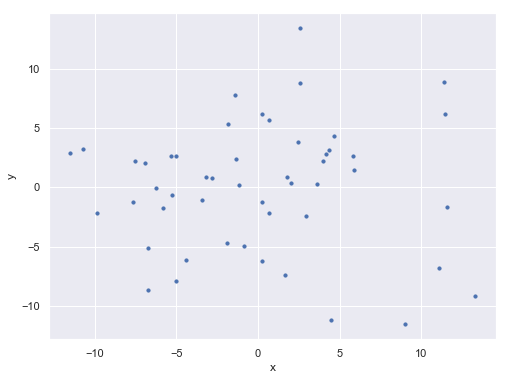

In [110]:
charpoints.plot.scatter("x", "y", s=10, figsize=(8, 6))
plt.show()

In [111]:
def plot_region(dataframe,x_bounds, y_bounds):
    slice = dataframe[
        (x_bounds[0] <= dataframe.x) &
        (dataframe.x <= x_bounds[1]) & 
        (y_bounds[0] <= dataframe.y) &
        (dataframe.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.010, point.y + 0.006, Namelist[point.name], fontsize=11)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


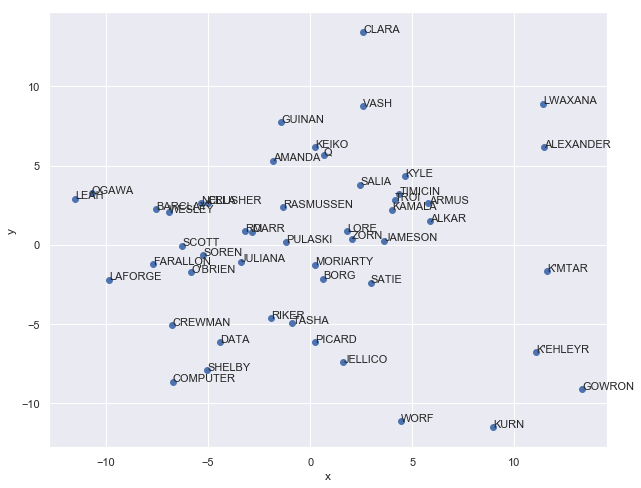

In [112]:
plot_region(charpoints, x_bounds=(-20,20), y_bounds=(-20,20))

In [113]:
#set up for plotting clusters
def plot_clusters(dataframe,clusters,x_bounds, y_bounds,colormap='rainbow'):
    slice = dataframe[
        (x_bounds[0] <= dataframe.x) &
        (dataframe.x <= x_bounds[1]) & 
        (y_bounds[0] <= dataframe.y) &
        (dataframe.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", c=clusters, colormap=colormap, s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.008, point.y + 0.006, Namelist[point.name], fontsize=11)

In [114]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering

In [115]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(155, 100), dpi=80, facecolor='w', edgecolor='k')

<Figure size 12400x8000 with 0 Axes>

<Figure size 12400x8000 with 0 Axes>

In [116]:
Vectors = character_vectors
len(Vectors),len(Namelist)

(50, 50)

In [118]:
#KMeans?

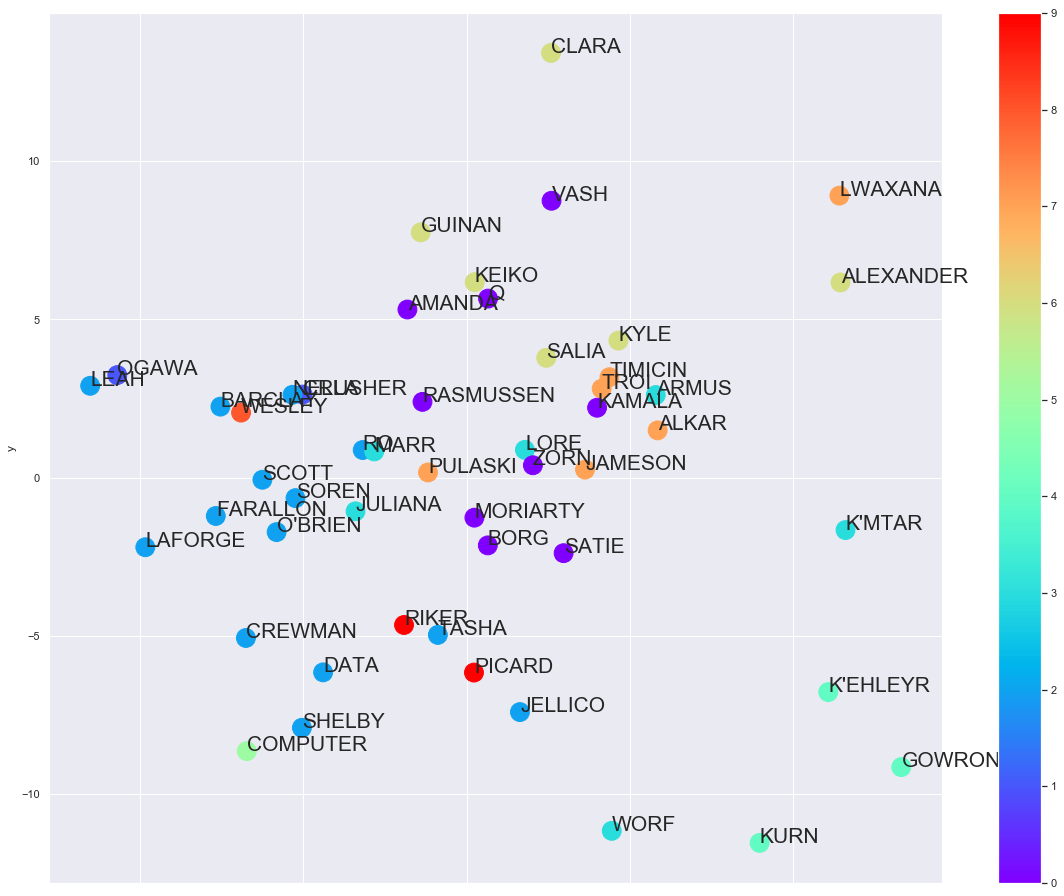

In [119]:
KM_model = KMeans(n_clusters= 10,n_jobs=-1, random_state = 42, max_iter = 100000)
clusters = KM_model.fit_predict(Vectors)
ii = np.argsort(clusters)
list(zip(np.array(Namelist)[ii],clusters[ii]))
x_bounds=(-530,530)
y_bounds=(-800,800)
slice = charpoints[
    (x_bounds[0] <= charpoints.x) &
    (charpoints.x <= x_bounds[1]) & 
    (y_bounds[0] <= charpoints.y) &
    (charpoints.y <= y_bounds[1])
]

ax = slice.plot.scatter("x", "y", c=list(clusters), colormap='rainbow', s=355, figsize=(20, 16))
for i, point in slice.iterrows():
    ax.text(point.x + 0.004, point.y + 0.003, Namelist[point.name], fontsize=21)

# Evaluate the Results 

In [120]:
ii = np.argsort(clusters)
namegrouplist = list(zip(np.array(Namelist)[ii],clusters[ii]))
namegrouplist

[('Q', 0),
 ('MORIARTY', 0),
 ('BORG', 0),
 ('ZORN', 0),
 ('SATIE', 0),
 ('VASH', 0),
 ('RASMUSSEN', 0),
 ('AMANDA', 0),
 ('KAMALA', 0),
 ('CRUSHER', 1),
 ('OGAWA', 1),
 ('SHELBY', 2),
 ('JELLICO', 2),
 ('SCOTT', 2),
 ('SOREN', 2),
 ('NELLA', 2),
 ('LEAH', 2),
 ('FARALLON', 2),
 ('BARCLAY', 2),
 ('RO', 2),
 ('CREWMAN', 2),
 ('DATA', 2),
 ("O'BRIEN", 2),
 ('LAFORGE', 2),
 ('TASHA', 2),
 ('ARMUS', 3),
 ('JULIANA', 3),
 ("K'MTAR", 3),
 ('WORF', 3),
 ('LORE', 3),
 ('MARR', 3),
 ("K'EHLEYR", 4),
 ('KURN', 4),
 ('GOWRON', 4),
 ('COMPUTER', 5),
 ('ALEXANDER', 6),
 ('GUINAN', 6),
 ('CLARA', 6),
 ('SALIA', 6),
 ('KYLE', 6),
 ('KEIKO', 6),
 ('TIMICIN', 7),
 ('ALKAR', 7),
 ('LWAXANA', 7),
 ('PULASKI', 7),
 ('TROI', 7),
 ('JAMESON', 7),
 ('WESLEY', 8),
 ('RIKER', 9),
 ('PICARD', 9)]

In [133]:
json_data = """{
  "nodes": [
"""

for name,group in namegrouplist:
    json_data = json_data + "    {\"id\": \"" + name + "\", \"group\": " + str(group) + "},\n"

json_data = json_data[:-2] + """   ],      
  "links": [ 
"""  #[:-2] leaves out ,\n on last line before adding square bracket

for line in interaction_map:
    if line[2]>=15:
        json_data = json_data + "    {\"source\": \"" + line[0] + "\", \"target\": \"" + line[1] + "\", \"value\": " + str(line[2]) + "},\n"

json_data = json_data[:-2] + """  ]
}"""

In [134]:
print(json_data)

{
  "nodes": [
    {"id": "Q", "group": 0},
    {"id": "MORIARTY", "group": 0},
    {"id": "BORG", "group": 0},
    {"id": "ZORN", "group": 0},
    {"id": "SATIE", "group": 0},
    {"id": "VASH", "group": 0},
    {"id": "RASMUSSEN", "group": 0},
    {"id": "AMANDA", "group": 0},
    {"id": "KAMALA", "group": 0},
    {"id": "CRUSHER", "group": 1},
    {"id": "OGAWA", "group": 1},
    {"id": "SHELBY", "group": 2},
    {"id": "JELLICO", "group": 2},
    {"id": "SCOTT", "group": 2},
    {"id": "SOREN", "group": 2},
    {"id": "NELLA", "group": 2},
    {"id": "LEAH", "group": 2},
    {"id": "FARALLON", "group": 2},
    {"id": "BARCLAY", "group": 2},
    {"id": "RO", "group": 2},
    {"id": "CREWMAN", "group": 2},
    {"id": "DATA", "group": 2},
    {"id": "O'BRIEN", "group": 2},
    {"id": "LAFORGE", "group": 2},
    {"id": "TASHA", "group": 2},
    {"id": "ARMUS", "group": 3},
    {"id": "JULIANA", "group": 3},
    {"id": "K'MTAR", "group": 3},
    {"id": "WORF", "group": 3},
    {"id": "L

In [135]:
import json
with open('data.json', 'w', encoding='utf-8') as f:
    json.dump(json_data, f, ensure_ascii=False, indent=4)

# Measure Centrality 

In [123]:
import networkx as nx
from networkx.readwrite import json_graph

In [124]:
H = json_graph.node_link_graph(({ 
    "nodes": [
    {"id": "Q", "group": 0},
    {"id": "MORIARTY", "group": 0},
    {"id": "BORG", "group": 0},
    {"id": "ZORN", "group": 0},
    {"id": "SATIE", "group": 0},
    {"id": "VASH", "group": 0},
    {"id": "RASMUSSEN", "group": 0},
    {"id": "AMANDA", "group": 0},
    {"id": "KAMALA", "group": 0},
    {"id": "CRUSHER", "group": 1},
    {"id": "OGAWA", "group": 1},
    {"id": "SHELBY", "group": 2},
    {"id": "JELLICO", "group": 2},
    {"id": "SCOTT", "group": 2},
    {"id": "SOREN", "group": 2},
    {"id": "NELLA", "group": 2},
    {"id": "LEAH", "group": 2},
    {"id": "FARALLON", "group": 2},
    {"id": "BARCLAY", "group": 2},
    {"id": "RO", "group": 2},
    {"id": "CREWMAN", "group": 2},
    {"id": "DATA", "group": 2},
    {"id": "O'BRIEN", "group": 2},
    {"id": "LAFORGE", "group": 2},
    {"id": "TASHA", "group": 2},
    {"id": "ARMUS", "group": 3},
    {"id": "JULIANA", "group": 3},
    {"id": "K'MTAR", "group": 3},
    {"id": "WORF", "group": 3},
    {"id": "LORE", "group": 3},
    {"id": "MARR", "group": 3},
    {"id": "K'EHLEYR", "group": 4},
    {"id": "KURN", "group": 4},
    {"id": "GOWRON", "group": 4},
    {"id": "COMPUTER", "group": 5},
    {"id": "ALEXANDER", "group": 6},
    {"id": "GUINAN", "group": 6},
    {"id": "CLARA", "group": 6},
    {"id": "SALIA", "group": 6},
    {"id": "KYLE", "group": 6},
    {"id": "KEIKO", "group": 6},
    {"id": "TIMICIN", "group": 7},
    {"id": "ALKAR", "group": 7},
    {"id": "LWAXANA", "group": 7},
    {"id": "PULASKI", "group": 7},
    {"id": "TROI", "group": 7},
    {"id": "JAMESON", "group": 7},
    {"id": "WESLEY", "group": 8},
    {"id": "RIKER", "group": 9},
    {"id": "PICARD", "group": 9}   ],      
  "links": [ 
    {"source": "PICARD", "target": "RIKER", "value": 6194},
    {"source": "PICARD", "target": "DATA", "value": 5751},
    {"source": "PICARD", "target": "LAFORGE", "value": 3291},
    {"source": "PICARD", "target": "WORF", "value": 3526},
    {"source": "PICARD", "target": "CRUSHER", "value": 2853},
    {"source": "PICARD", "target": "TROI", "value": 2196},
    {"source": "PICARD", "target": "WESLEY", "value": 1088},
    {"source": "PICARD", "target": "Q", "value": 1379},
    {"source": "PICARD", "target": "TASHA", "value": 642},
    {"source": "PICARD", "target": "COMPUTER", "value": 432},
    {"source": "PICARD", "target": "O'BRIEN", "value": 368},
    {"source": "PICARD", "target": "PULASKI", "value": 436},
    {"source": "PICARD", "target": "GUINAN", "value": 283},
    {"source": "PICARD", "target": "LWAXANA", "value": 187},
    {"source": "PICARD", "target": "RO", "value": 3218},
    {"source": "PICARD", "target": "BARCLAY", "value": 90},
    {"source": "PICARD", "target": "VASH", "value": 315},
    {"source": "PICARD", "target": "K'EHLEYR", "value": 79},
    {"source": "PICARD", "target": "JELLICO", "value": 52},
    {"source": "PICARD", "target": "MORIARTY", "value": 106},
    {"source": "PICARD", "target": "GOWRON", "value": 85},
    {"source": "PICARD", "target": "LORE", "value": 58},
    {"source": "PICARD", "target": "SCOTT", "value": 47},
    {"source": "PICARD", "target": "RASMUSSEN", "value": 87},
    {"source": "PICARD", "target": "NELLA", "value": 138},
    {"source": "PICARD", "target": "KAMALA", "value": 153},
    {"source": "PICARD", "target": "ARMUS", "value": 77},
    {"source": "PICARD", "target": "JAMESON", "value": 116},
    {"source": "PICARD", "target": "MARR", "value": 59},
    {"source": "PICARD", "target": "FARALLON", "value": 40},
    {"source": "PICARD", "target": "TIMICIN", "value": 47},
    {"source": "PICARD", "target": "CREWMAN", "value": 103},
    {"source": "PICARD", "target": "BORG", "value": 72},
    {"source": "PICARD", "target": "SATIE", "value": 133},
    {"source": "PICARD", "target": "ZORN", "value": 90},
    {"source": "PICARD", "target": "ALKAR", "value": 62},
    {"source": "RIKER", "target": "DATA", "value": 3694},
    {"source": "RIKER", "target": "LAFORGE", "value": 2404},
    {"source": "RIKER", "target": "WORF", "value": 2580},
    {"source": "RIKER", "target": "CRUSHER", "value": 1387},
    {"source": "RIKER", "target": "TROI", "value": 1628},
    {"source": "RIKER", "target": "WESLEY", "value": 749},
    {"source": "RIKER", "target": "Q", "value": 422},
    {"source": "RIKER", "target": "TASHA", "value": 413},
    {"source": "RIKER", "target": "COMPUTER", "value": 241},
    {"source": "RIKER", "target": "O'BRIEN", "value": 282},
    {"source": "RIKER", "target": "PULASKI", "value": 259},
    {"source": "RIKER", "target": "GUINAN", "value": 125},
    {"source": "RIKER", "target": "LWAXANA", "value": 86},
    {"source": "RIKER", "target": "RO", "value": 2018},
    {"source": "RIKER", "target": "BARCLAY", "value": 86},
    {"source": "RIKER", "target": "K'EHLEYR", "value": 42},
    {"source": "RIKER", "target": "JELLICO", "value": 106},
    {"source": "RIKER", "target": "MORIARTY", "value": 53},
    {"source": "RIKER", "target": "SOREN", "value": 202},
    {"source": "RIKER", "target": "SHELBY", "value": 178},
    {"source": "RIKER", "target": "NELLA", "value": 44},
    {"source": "RIKER", "target": "AMANDA", "value": 52},
    {"source": "RIKER", "target": "KYLE", "value": 74},
    {"source": "RIKER", "target": "CREWMAN", "value": 54},
    {"source": "RIKER", "target": "ZORN", "value": 78},
    {"source": "DATA", "target": "LAFORGE", "value": 3132},
    {"source": "DATA", "target": "WORF", "value": 1690},
    {"source": "DATA", "target": "CRUSHER", "value": 920},
    {"source": "DATA", "target": "TROI", "value": 1096},
    {"source": "DATA", "target": "WESLEY", "value": 418},
    {"source": "DATA", "target": "Q", "value": 317},
    {"source": "DATA", "target": "TASHA", "value": 264},
    {"source": "DATA", "target": "COMPUTER", "value": 296},
    {"source": "DATA", "target": "O'BRIEN", "value": 209},
    {"source": "DATA", "target": "PULASKI", "value": 226},
    {"source": "DATA", "target": "GUINAN", "value": 165},
    {"source": "DATA", "target": "LWAXANA", "value": 50},
    {"source": "DATA", "target": "RO", "value": 1355},
    {"source": "DATA", "target": "BARCLAY", "value": 100},
    {"source": "DATA", "target": "LORE", "value": 129},
    {"source": "DATA", "target": "RASMUSSEN", "value": 68},
    {"source": "DATA", "target": "KEIKO", "value": 52},
    {"source": "DATA", "target": "MARR", "value": 131},
    {"source": "DATA", "target": "FARALLON", "value": 96},
    {"source": "DATA", "target": "JULIANA", "value": 159},
    {"source": "LAFORGE", "target": "WORF", "value": 987},
    {"source": "LAFORGE", "target": "CRUSHER", "value": 781},
    {"source": "LAFORGE", "target": "TROI", "value": 554},
    {"source": "LAFORGE", "target": "WESLEY", "value": 463},
    {"source": "LAFORGE", "target": "Q", "value": 293},
    {"source": "LAFORGE", "target": "TASHA", "value": 182},
    {"source": "LAFORGE", "target": "COMPUTER", "value": 321},
    {"source": "LAFORGE", "target": "O'BRIEN", "value": 166},
    {"source": "LAFORGE", "target": "PULASKI", "value": 124},
    {"source": "LAFORGE", "target": "GUINAN", "value": 124},
    {"source": "LAFORGE", "target": "RO", "value": 776},
    {"source": "LAFORGE", "target": "BARCLAY", "value": 328},
    {"source": "LAFORGE", "target": "JELLICO", "value": 48},
    {"source": "LAFORGE", "target": "LEAH", "value": 236},
    {"source": "LAFORGE", "target": "SCOTT", "value": 143},
    {"source": "LAFORGE", "target": "SHELBY", "value": 40},
    {"source": "LAFORGE", "target": "FARALLON", "value": 95},
    {"source": "LAFORGE", "target": "CREWMAN", "value": 56},
    {"source": "LAFORGE", "target": "BORG", "value": 102},
    {"source": "WORF", "target": "CRUSHER", "value": 560},
    {"source": "WORF", "target": "TROI", "value": 892},
    {"source": "WORF", "target": "WESLEY", "value": 229},
    {"source": "WORF", "target": "Q", "value": 265},
    {"source": "WORF", "target": "TASHA", "value": 145},
    {"source": "WORF", "target": "COMPUTER", "value": 109},
    {"source": "WORF", "target": "O'BRIEN", "value": 113},
    {"source": "WORF", "target": "PULASKI", "value": 88},
    {"source": "WORF", "target": "GUINAN", "value": 63},
    {"source": "WORF", "target": "LWAXANA", "value": 41},
    {"source": "WORF", "target": "RO", "value": 1175},
    {"source": "WORF", "target": "ALEXANDER", "value": 268},
    {"source": "WORF", "target": "K'EHLEYR", "value": 166},
    {"source": "WORF", "target": "GOWRON", "value": 118},
    {"source": "WORF", "target": "KURN", "value": 119},
    {"source": "WORF", "target": "KEIKO", "value": 40},
    {"source": "WORF", "target": "K'MTAR", "value": 101},
    {"source": "CRUSHER", "target": "TROI", "value": 734},
    {"source": "CRUSHER", "target": "WESLEY", "value": 386},
    {"source": "CRUSHER", "target": "Q", "value": 235},
    {"source": "CRUSHER", "target": "TASHA", "value": 51},
    {"source": "CRUSHER", "target": "COMPUTER", "value": 159},
    {"source": "CRUSHER", "target": "O'BRIEN", "value": 74},
    {"source": "CRUSHER", "target": "GUINAN", "value": 86},
    {"source": "CRUSHER", "target": "RO", "value": 879},
    {"source": "CRUSHER", "target": "BARCLAY", "value": 102},
    {"source": "CRUSHER", "target": "OGAWA", "value": 252},
    {"source": "CRUSHER", "target": "AMANDA", "value": 67},
    {"source": "CRUSHER", "target": "BORG", "value": 42},
    {"source": "TROI", "target": "WESLEY", "value": 96},
    {"source": "TROI", "target": "Q", "value": 206},
    {"source": "TROI", "target": "TASHA", "value": 117},
    {"source": "TROI", "target": "COMPUTER", "value": 84},
    {"source": "TROI", "target": "O'BRIEN", "value": 100},
    {"source": "TROI", "target": "PULASKI", "value": 224},
    {"source": "TROI", "target": "GUINAN", "value": 62},
    {"source": "TROI", "target": "LWAXANA", "value": 367},
    {"source": "TROI", "target": "RO", "value": 7757},
    {"source": "TROI", "target": "BARCLAY", "value": 158},
    {"source": "TROI", "target": "ALEXANDER", "value": 48},
    {"source": "TROI", "target": "K'EHLEYR", "value": 47},
    {"source": "TROI", "target": "ARMUS", "value": 67},
    {"source": "TROI", "target": "CLARA", "value": 64},
    {"source": "TROI", "target": "KYLE", "value": 40},
    {"source": "TROI", "target": "ZORN", "value": 42},
    {"source": "TROI", "target": "ALKAR", "value": 84},
    {"source": "WESLEY", "target": "COMPUTER", "value": 46},
    {"source": "WESLEY", "target": "GUINAN", "value": 87},
    {"source": "WESLEY", "target": "RO", "value": 251},
    {"source": "WESLEY", "target": "SALIA", "value": 117},
    {"source": "Q", "target": "TASHA", "value": 62},
    {"source": "Q", "target": "GUINAN", "value": 51},
    {"source": "Q", "target": "RO", "value": 322},
    {"source": "Q", "target": "VASH", "value": 56},
    {"source": "Q", "target": "AMANDA", "value": 99},
    {"source": "TASHA", "target": "RO", "value": 126},
    {"source": "COMPUTER", "target": "RO", "value": 95},
    {"source": "O'BRIEN", "target": "RO", "value": 164},
    {"source": "O'BRIEN", "target": "BARCLAY", "value": 83},
    {"source": "O'BRIEN", "target": "KEIKO", "value": 96},
    {"source": "PULASKI", "target": "RO", "value": 224},
    {"source": "PULASKI", "target": "KYLE", "value": 58},
    {"source": "GUINAN", "target": "RO", "value": 167},
    {"source": "LWAXANA", "target": "RO", "value": 367},
    {"source": "LWAXANA", "target": "ALEXANDER", "value": 58},
    {"source": "LWAXANA", "target": "TIMICIN", "value": 110},
    {"source": "RO", "target": "BARCLAY", "value": 161},
    {"source": "RO", "target": "ALEXANDER", "value": 51},
    {"source": "RO", "target": "K'EHLEYR", "value": 70},
    {"source": "RO", "target": "GOWRON", "value": 270},
    {"source": "RO", "target": "ARMUS", "value": 67},
    {"source": "RO", "target": "CLARA", "value": 64},
    {"source": "RO", "target": "KYLE", "value": 40},
    {"source": "RO", "target": "ZORN", "value": 42},
    {"source": "RO", "target": "ALKAR", "value": 84},
    {"source": "BARCLAY", "target": "MORIARTY", "value": 40},
    {"source": "ALEXANDER", "target": "K'MTAR", "value": 57}  ]
}));

In [125]:
nx.degree_centrality(H)
sorted(nx.degree_centrality(H).items(), key=lambda x: x[1], reverse = True)[:11]

[('PICARD', 0.7346938775510203),
 ('RIKER', 0.5306122448979591),
 ('RO', 0.4897959183673469),
 ('TROI', 0.4693877551020408),
 ('DATA', 0.44897959183673464),
 ('LAFORGE', 0.44897959183673464),
 ('WORF', 0.42857142857142855),
 ('CRUSHER', 0.3469387755102041),
 ('Q', 0.24489795918367346),
 ('WESLEY', 0.22448979591836732),
 ("O'BRIEN", 0.2040816326530612)]